In [2]:
from glob import glob
import numpy as np
import pandas as pd
from plotnine import *
import os

In [3]:
pd.set_option('display.max_rows', None)

In [10]:
# data directories
datadir1 = '/Users/rosekantor/data/wbe_scv/qb3_artic_033021/artic'
datadir2 = '/Users/rosekantor/data/wbe_scv/qb3_artic_050721/'
datadir3 = '/Users/rosekantor/data/wbe_scv/qb3_artic_052621'
datadir4 = '/Users/rosekantor/data/wbe_scv/qb3_artic_062921'
datadir5 = '/Users/rosekantor/data/wbe_scv/qb3_artic_073021'
datadir6 = '/Users/rosekantor/data/wbe_scv/qb3_artic_080721'

dirs = [datadir1, datadir2, datadir3, datadir4, datadir5, datadir6]

# Collecting info

## Sample names

In [11]:
# sample_id is the unique ID for each sequencing run (some samples were run multiple times and must have unique names), (all files should use these names)
# original_id is what things were called in the data
# merge_id is the sample name for qPCR data

batch1 = pd.read_csv(f'{datadir1}/samples_df.csv')
batch1 = batch1[['sample_id', 'sample', 'fragment_analyzer_band']]
batch1 = batch1.rename(columns={'sample':'original_id'})
batch1['merge_id'] = batch1['sample_id']
batch1['batch'] = 1

batch2 = pd.read_csv(f'{datadir2}/samples_df.csv')
batch2 = batch2[['sample_id', 'tube_name']]
batch2 = batch2.rename(columns={'tube_name':'original_id'})
batch2['merge_id'] = batch2['sample_id']
batch2['batch'] = 2
# rename this sample's merge_id since the date was wrong on the tube (SFPUC systematic error)
batch2.loc[batch2.sample_id == 'D_OSP_INF_042221_1', 'merge_id'] = 'D_OSP_INF_042121_1'


In [12]:

batch3 = pd.read_csv(f'{datadir3}/samples_df.csv')
batch3 = batch3.rename(columns={'sample':'sample_id'})
batch3 = batch3[['sample_id']]
batch3['original_id'] = batch3['sample_id']
batch3['merge_id'] = batch3['sample_id']
batch3['batch'] = 3
# rename this sample's merge_id since the date was wrong on the tube (SFPUC systematic error)
# also looks like replicate 1 doesn't have data, so using replicate 2 here
batch3.loc[batch3.merge_id == 'D_OSP_INF_050621_1', 'merge_id'] = 'D_OSP_INF_050521_2'

batch4 = pd.read_csv(f'{datadir4}/samples_df.csv')
batch4 = batch4[['sample', 'sample_id', 'treatment']]
batch4 = batch4.rename(columns={'sample_id':'merge_id',
                                'sample': 'sample_id'
                               })
batch4['original_id'] = batch4['sample_id'] # merge_id already exists
batch4['batch'] = 4
# rename this sample's merge_id since the date was wrong on the tube (SFPUC systematic error)
batch4.loc[batch4.merge_id == 'D_SEP_INF_052721_2', 'merge_id'] = 'D_SEP_INF_052621_2'

batch5 = pd.read_csv(f'{datadir5}/samples_df.csv')
batch5 = batch5.rename(columns={'sample_id':'original_id',
                                'sample':'sample_id'
                               })
batch5['merge_id'] = batch5['original_id'].copy()
# we extracted replicate #4 with Amicon and Nanotrap. 
# Here I'm linking these samples to another sample in the inventory to get the date, etc.
# for these samples, either the #1 or #2 clogged, so we have to link to a specific sample that didn't clog
batch5.loc[batch5.merge_id == 'C_C_INF_070121_4', 'merge_id'] = 'C_C_INF_070121_1'
batch5.loc[batch5.merge_id == 'M_M_INF_070121_4', 'merge_id'] = 'M_M_INF_070121_2'
batch5.loc[batch5.merge_id == 'O_O_INF_070121_4', 'merge_id'] = 'O_O_INF_070121_2'
 
batch5.merge_id = batch5.merge_id.str.replace(r'_4$', '_2', regex=True)
batch5['batch'] = 5

batch6 = pd.read_csv(f'{datadir6}/samples_df.csv')
batch6 = batch6.rename(columns={'sample_id':'original_id',
                                'sample':'sample_id'
                               })
batch6['merge_id'] = batch6['original_id'].copy()
batch6['batch'] = 6

all_samples = pd.concat([batch1, batch2, batch3, batch4, batch5, batch6])
all_samples = all_samples.drop(columns = ['read1', 'read2'])

In [13]:
# pull sample code and replicate number out of the sample id
all_samples['sample_code'] = all_samples.merge_id.str.extract(r'(\w+_\w+_\w+)_\d+_\d+')
all_samples['rep'] = all_samples.merge_id.str.extract(r'\w+_\w+_\w+_\d+_(\d+)')

# fill in missing "treatment" with "std" because if not specified, it was standard
all_samples.loc[all_samples.treatment.isna(), 'treatment'] = 'std'

In [14]:
all_samples.tail()

,sample_id,original_id,fragment_analyzer_band,merge_id,batch,treatment,sample_code,rep
11,J_J_UVANE_071621_2,J_J_UVANE_071621_2,NaN,J_J_UVANE_071621_2,6,std,J_J_UVANE,2
12,K_K_INF_071121_2,K_K_INF_071121_2,NaN,K_K_INF_071121_2,6,std,K_K_INF,2
13,K_K_INF_071521_2,K_K_INF_071521_2,NaN,K_K_INF_071521_2,6,std,K_K_INF,2
14,L_L_INF_071221_3,L_L_INF_071221_3,NaN,L_L_INF_071221_3,6,std,L_L_INF,3
15,L_L_INF_071421_2,L_L_INF_071421_2,NaN,L_L_INF_071421_2,6,std,L_L_INF,2


In [15]:
all_samples.loc[all_samples.sample_id == 'M_M_INF_011721_3', 'merge_id'] = 'M_M_INF_011721_1' # only reps 1 and 2 were analyzed
all_samples.loc[all_samples.sample_id == 'K_K_INF_011821_3', 'merge_id'] = 'K_K_INF_011821_1' # only reps 1 and 2 were analyzed
all_samples.loc[all_samples.sample_id == 'M_M_INF_011921_3', 'merge_id'] = 'M_M_INF_011921_1' # only reps 1 and 2 were analyzed
all_samples.loc[all_samples.sample_id == 'N_N_INF_040621_3', 'merge_id'] = 'N_N_INF_040621_1' # only reps 1 and 2 were analyzed
all_samples.loc[all_samples.sample_id == 'L_L_INF_040621_2', 'merge_id'] = 'L_L_INF_040421_1' # there was no sample on 4/6
all_samples.loc[all_samples.sample_id == 'D_SEP_Rosenburg_122220_2', 'merge_id'] = 'D_SEP_Rosenburg_122220_1'
all_samples.loc[all_samples.sample_id == 'D_SEP_NF_042821_2', 'merge_id'] = 'D_SEP_NF_042821_1'

## Sample Cqs

In [16]:
# run the pipeline to pull quantification and sample inventory data from labcollector and analyze. Then load the file.
qpcr_data = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/full_wastewater_dataset_newformat_with_residential.csv'
#qpcr_data = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/full_wastewater_dataset_newformat_gdrive.csv'

qpcr_df_all = pd.read_csv(qpcr_data)

qpcr_df_all = qpcr_df_all[['Sample','date_sampling', 'county', 'site_full_name', 'detected_of_3_TechReps', #'Cq_mean',
                   'SARS_CoV_2_N1_gc_per_mL', 'pmmov_gc_per_mL', 'quality_score', 'flag', 'point_deduction']]

qpcr_df = qpcr_df_all[qpcr_df_all.Sample.isin(all_samples.merge_id)]

In [17]:
set(all_samples.merge_id) - set(qpcr_df.Sample)

# M_M_INF_070121_1 clogged, not quantified
# D_OSP_INF_071121_1 clogged, not quantified
# O_O_INF_070121_1 clogged, not quantified

# all_samples[all_samples.merge_id.isin(['M_M_INF_070121_1',
# 'O_O_INF_070121_1',
# 'D_OSP_INF_071121_1'])]

{'C_C_INF_070121_1',
 'D_OSP_INF_071121_3',
 'K_K_INF_071121_2',
 'M_M_INF_070121_2',
 'O_O_INF_070121_2',
 'Q_Q_CMF_010521_1',
 'R_R_Alvarado_070121_1',
 'R_R_Alvarado_070121_2',
 'control_control_PBS_012021_1'}

## Total reads

In [18]:
# need to run this in the mapping_logs directory before running the cells below:
# grep 'reads; of these:' *log | sed 's/ reads; of these://g' > read_counts.txt

In [19]:
readcounts_df = []
for i in dirs:
    reads_df = pd.read_csv(f'{i}/mapping_logs/read_counts.txt', sep=':', names=['sample_id', 'reads'])
    reads_df.sample_id = reads_df.sample_id.str.extract(r'(.+)\.log') #remove ".log" from sample names in column
    readcounts_df.append(reads_df)
readcounts_df = pd.concat(readcounts_df)

## Percent mapped (bowtie2)

In [20]:
# need to run this in the mapping_logs directory before running the cells below:
# grep 'overall' *log | sed 's/% overall alignment rate//g' > perc_mapped.txt

In [21]:
mapping_df = []
for i in dirs:
    mapped = pd.read_csv(f'{i}/mapping_logs/perc_mapped.txt', sep=':', names=['sample_id', 'perc_mapped'])
    mapped.sample_id = mapped.sample_id.str.extract(r'(.+)\.log') #remove ".log" from sample names in column
    mapping_df.append(mapped)
mapping_df = pd.concat(mapping_df)

## Coverage depth and breadth
Note that samtools depth doesn't report positions with 0 coverage.

We will use coverage info later to look for positions where there was coverage but no mutations were detected (vs positions that just had no coverage).

In [22]:
# read in all files and combine into df
depth_df = []
for batch in range(0,len(dirs)):
    for f in glob(f'{dirs[batch]}/depth/*depth.txt'):
        s = os.path.basename(f).split('.')[0]
        df = pd.read_csv(f, sep='\t', names=['ref', 'position', 'coverage'])
        df['sample_id'] = s
        depth_df.append(df)
depth_df = pd.concat(depth_df)

In [23]:
# calculate fraction of genome with greater than 400x coverage (as required by iVar for good variant-calling)
genome_len = 29903

acceptable_cov_df = []
for s, df in depth_df.groupby('sample_id'):
    perc_400x = np.round(100 * len(df[df.coverage >= 400]) / genome_len)
    perc_100x = np.round(100 * len(df[df.coverage >= 100]) / genome_len)
    perc_10x = np.round(100 * len(df[df.coverage >= 10]) / genome_len)
    perc_5x = np.round(100 * len(df[df.coverage >= 5]) / genome_len)
    acceptable_cov_df.append([s, perc_400x, perc_100x, perc_10x, perc_5x])
acceptable_cov_df = pd.DataFrame.from_records(acceptable_cov_df, columns=['sample_id',
                                                                          'perc_over_400x',
                                                                          'perc_over_100x',
                                                                          'perc_over_10x',
                                                                          'perc_over_5x'
                                                                         ])

### Coverage of the S-gene

In [24]:
# percent of spike gene with coverage > x

# calculate fraction of genome with greater than 400x coverage (as required by iVar for good variant-calling)
genome_len = 25384 - 21563 + 1

depth_df.position = depth_df.position.astype('int')
depth_df.coverage = depth_df.coverage.astype('int')
depth_spike_df = depth_df[(depth_df.position >= 21563) &
                          (depth_df.position <= 25384) & 
                          (depth_df.coverage > 10)]

spike_cov_df = []
for s, df in depth_spike_df.groupby('sample_id'):
    perc_400x = np.round(100 * len(df[df.coverage >= 400]) / genome_len)
    perc_100x = np.round(100 * len(df[df.coverage >= 100]) / genome_len)
    perc_10x = np.round(100 * len(df[df.coverage >= 10]) / genome_len)
    perc_5x = np.round(100 * len(df[df.coverage >= 5]) / genome_len)
    spike_cov_df.append([s, perc_400x, perc_100x, perc_10x, perc_5x])
spike_cov_df = pd.DataFrame.from_records(spike_cov_df, columns=['sample_id',
                                                                          'spike_perc_over_400x',
                                                                          'spike_perc_over_100x',
                                                                          'spike_perc_over_10x',
                                                                          'spike_perc_over_5x'
                                                                         ])

## Merge all tables

In [25]:
# merge tables
stats_df = all_samples.merge(qpcr_df, how='left', left_on='merge_id', right_on='Sample') # note that a few are missing from our samples inventory and/or were not run for qPCR

stats_df = stats_df.merge(readcounts_df, how='left', on='sample_id')
stats_df = stats_df.merge(mapping_df, how='left', on='sample_id')
stats_df = stats_df.merge(acceptable_cov_df, how='left', on='sample_id')
stats_df = stats_df.merge(spike_cov_df, how='left', on='sample_id')

# fill in missing dates (missing because never run for qpcr or not in db)
stats_df.loc[stats_df.sample_id == 'control_control_PBS_012021_1', 'date_sampling'] = '2021-01-20'
stats_df.loc[stats_df.sample_id == 'D_SEP_Rosenburg_122220_2', 'date_sampling'] = '2020-12-22'
stats_df.loc[stats_df.sample_id == 'K_K_INF_011821_3', 'date_sampling'] = '2021-01-18'
stats_df.loc[stats_df.sample_id == 'M_M_INF_011721_3', 'date_sampling'] = '2021-01-17'
stats_df.loc[stats_df.sample_id == 'M_M_INF_011921_3', 'date_sampling'] = '2021-01-19'
stats_df.loc[stats_df.sample_id == 'N_N_INF_040621_3', 'date_sampling'] = '2021-04-06'
stats_df.loc[stats_df.sample_id == 'L_L_INF_040621_2', 'date_sampling'] = '2021-04-06' # should be 04/04?
stats_df.loc[stats_df.sample_id == 'D_SEP_NF_042821_2', 'date_sampling'] = '2021-04-28'


# fill in missing site full names (missing because never run for qpcr or not in db)
code2name = stats_df[['sample_code', 'site_full_name']].drop_duplicates().dropna()
stats_df = stats_df.drop(columns='site_full_name').merge(code2name, how='left', on='sample_code')

# set batch as category for plotting
stats_df.batch = stats_df.batch.astype('category')

In [26]:
# save
stats_df.to_csv('/Users/rosekantor/data/wbe_scv/sequencing_stats_thru_Aug2021.csv', index=False)

In [27]:
# inspect the most recent batch
stats_df[stats_df.batch == 6].drop(columns=['original_id', 'fragment_analyzer_band', 'merge_id', 'batch', 'rep', 'Sample', 'date_sampling',
                                           'sample_code', 'county', 'detected_of_3_TechReps', 'pmmov_gc_per_mL',
                                           'quality_score', 'flag', 'point_deduction'])

,sample_id,treatment,SARS_CoV_2_N1_gc_per_mL,reads,perc_mapped,perc_over_400x,perc_over_100x,perc_over_10x,perc_over_5x,spike_perc_over_400x,spike_perc_over_100x,spike_perc_over_10x,spike_perc_over_5x,site_full_name
162,C_C_S68_071421_1,std,72.725832,982527,99.96,50.0,60.0,68.0,70.0,43.0,44.0,53.0,53.0,South_Oakland
163,C_C_S68_071421_2,std,90.234530,1080086,99.92,50.0,60.0,69.0,71.0,36.0,37.0,37.0,37.0,South_Oakland
164,D_OSP_INF_071121_3,std,NaN,1591200,99.96,50.0,63.0,73.0,75.0,44.0,45.0,65.0,65.0,Oceanside Treatment Plant
165,D_OSP_INF_071421_1,std,125.395374,920049,99.97,41.0,52.0,60.0,63.0,36.0,45.0,45.0,45.0,Oceanside Treatment Plant
166,D_SEP_NF_071521_1,std,253.804374,967831,99.96,35.0,44.0,62.0,64.0,19.0,33.0,44.0,44.0,Newhall and Fairfax trunk line
167,D_SEP_NF_071521_3,std,179.696871,735521,99.91,51.0,61.0,69.0,72.0,33.0,44.0,52.0,52.0,Newhall and Fairfax trunk line
168,G_G_INF_071321_1,std,111.592051,1189857,99.85,30.0,45.0,52.0,55.0,18.0,29.0,35.0,35.0,Sausalito-Marin City Sanitary District
169,G_G_INF_071321_2,std,104.144847,1064650,99.52,34.0,44.0,53.0,58.0,24.0,34.0,41.0,41.0,Sausalito-Marin City Sanitary District
170,G_G_MCS_071321_1,std,649.857492,803225,99.96,57.0,67.0,76.0,81.0,49.0,52.0,72.0,72.0,Marin City station
171,G_G_MCS_071321_2,std,389.111117,972149,99.97,24.0,34.0,43.0,47.0,14.0,24.0,29.0,29.0,Marin City station


In [28]:
len(stats_df.sample_code.unique())

28

## Explore sequencing stats

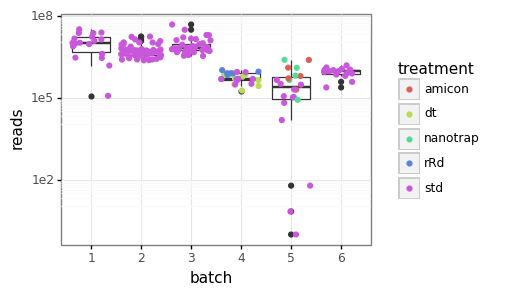

<ggplot: (321521399)>

In [29]:
(ggplot(stats_df, aes(x='batch', y='reads'))+
geom_boxplot()+
geom_jitter(stats_df, aes(color='treatment'))+
scale_y_log10()+
theme_bw()+
theme(figure_size=(4,3)))

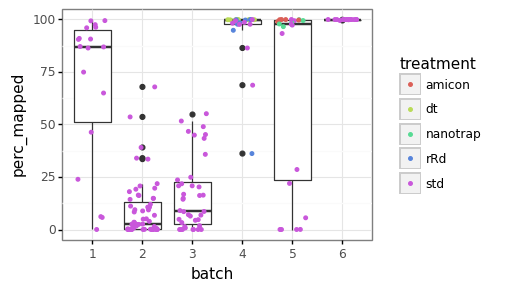

<ggplot: (321673207)>

In [30]:
stats_df.batch = stats_df.batch.astype('category')
(ggplot(stats_df, aes(x='batch', y='perc_mapped'))+
geom_boxplot()+
geom_jitter(stats_df, aes(color='treatment'), size=1, width=.3)+
theme_bw()+
theme(figure_size=(4,3)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 3 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 3 rows containing missing values.


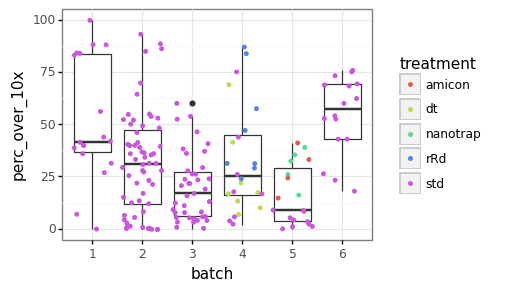

<ggplot: (321742586)>

In [31]:
(ggplot(stats_df, aes(x='batch', y='perc_over_10x'))+
geom_boxplot()+
geom_jitter(stats_df, aes(color='treatment'), size=1)+
theme_bw()+
theme(figure_size=(4,3)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 3 rows containing non-finite values.


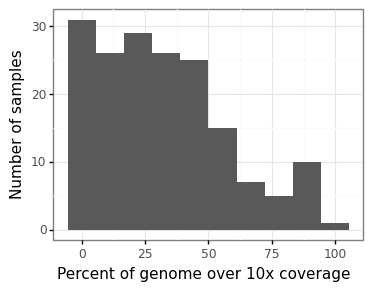

<ggplot: (321869821)>

In [32]:
(ggplot(stats_df, aes(x='perc_over_10x'))+
geom_histogram(bins=10)+
 xlab('Percent of genome over 10x coverage')+
 ylab('Number of samples')+
theme_bw()+
theme(figure_size=(4,3)))

In [33]:
# (ggplot(stats_df[stats_df.batch == 4], aes(x='merge_id', y='perc_over_5x', color='treatment'))+ #, color='Cq_mean'
#  geom_point(size=2)+
#  xlab('Sample')+
#  theme_bw()+
#  theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(4,3))
# )

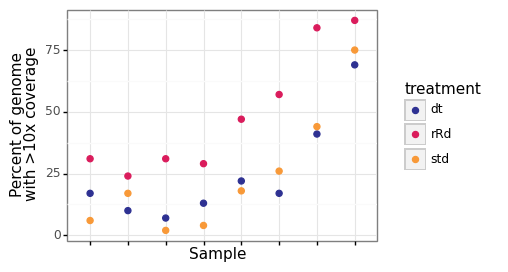

<ggplot: (321696681)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 3 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/figures/rRd_improvement.svg


In [35]:
colors = ['#2e3192','#da1c5c', '#f89938']
plt=(ggplot(stats_df[stats_df.batch == 4], aes(x='merge_id', y='perc_over_10x', color='treatment'))+ #, color='Cq_mean'
 geom_point(size=2)+
 scale_color_manual(values=colors)+
 xlab('Sample')+
 ylab('Percent of genome\nwith >10x coverage')+
 theme_bw()+
 theme(axis_text_x=element_blank(), figure_size=(4,3))#element_text(angle=45, hjust=1)
)
display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/figures/rRd_improvement.svg')

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


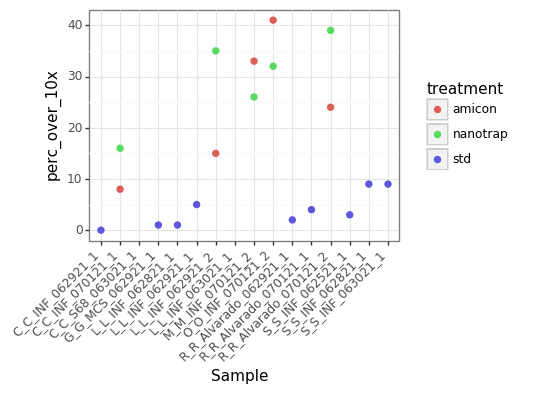

<ggplot: (305251581)>

In [415]:
(ggplot(stats_df[stats_df.batch == 5], aes(x='merge_id', y='perc_over_10x', color='treatment'))+ #, color='Cq_mean'
 geom_point(size=2)+
 xlab('Sample')+
 theme_bw()+
 theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(4,3))
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


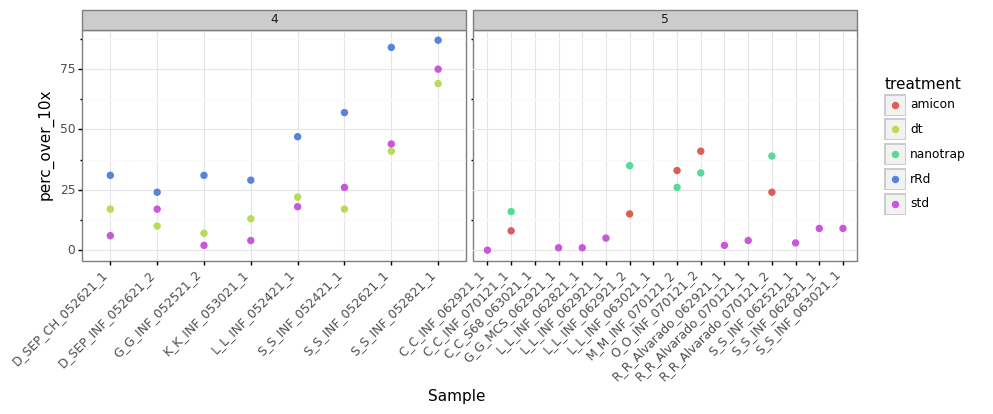

<ggplot: (306212148)>

In [38]:
(ggplot(stats_df[stats_df.batch.isin([4,5])], aes(x='merge_id', y='perc_over_10x', color='treatment'))+ #, color='Cq_mean'
 geom_point(size=2)+
 xlab('Sample')+
 theme_bw()+
 theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(10,3))+
 facet_wrap('~ batch', scales='free_x')
)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 46 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 46 rows containing missing values.


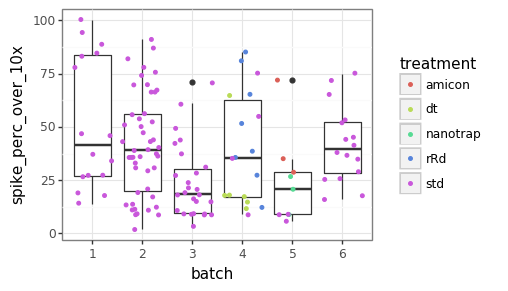

<ggplot: (305215813)>

In [140]:
(ggplot(stats_df, aes(x='batch', y='spike_perc_over_10x'))+
geom_boxplot()+
geom_jitter(stats_df, aes(color='treatment'), size=1)+
theme_bw()+
theme(figure_size=(4,3)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


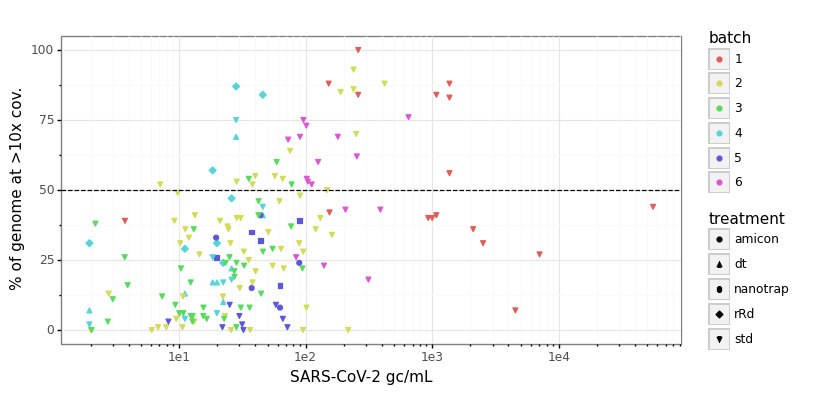

<ggplot: (309611162)>

In [44]:
(ggplot(stats_df, aes(x='SARS_CoV_2_N1_gc_per_mL', y='perc_over_10x', color='batch', shape='treatment'))+ #x=Cq_mean # removed because sometimes diluted 5x
geom_point()+
ylab('% of genome at >10x cov.')+
xlab('SARS-CoV-2 gc/mL')+
geom_hline(yintercept=50, linetype='dashed')+
scale_x_log10()+
theme_bw()+
theme(figure_size=(8,4)))

In [ ]:
# ultimately should try to get back to Cq since that is a direct quantification of the RNA in the tube

In [143]:
# display(len(stats_df[stats_df.Cq_mean > 30]))
# display(len(stats_df[(stats_df.Cq_mean > 30) & (stats_df.perc_over_10x > 50)]))

146

32

In [144]:
# display(len(stats_df[stats_df.Cq_mean < 30]))
# display(len(stats_df[(stats_df.Cq_mean < 30) & (stats_df.perc_over_10x > 50)]))

9

1

In [66]:
#stats_df[(stats_df.Cq_mean > 30) & (stats_df.perc_over_10x > 50)]

In [47]:
# samples with no county name failed to merge properly
stats_df.tail()

,sample_id,original_id,fragment_analyzer_band,merge_id,batch,treatment,sample_code,rep,Sample,date_sampling,...,perc_mapped,perc_over_400x,perc_over_100x,perc_over_10x,perc_over_5x,spike_perc_over_400x,spike_perc_over_100x,spike_perc_over_10x,spike_perc_over_5x,site_full_name
173,J_J_UVANE_071621_2,J_J_UVANE_071621_2,NaN,J_J_UVANE_071621_2,6,std,J_J_UVANE,2,J_J_UVANE_071621_2,2021-07-16,...,99.96,55.0,64.0,75.0,81.0,51.0,52.0,75.0,75.0,University Village Northeast
174,K_K_INF_071121_2,K_K_INF_071121_2,NaN,K_K_INF_071121_2,6,std,K_K_INF,2,K_K_INF_071121_2,2021-07-11,...,99.96,32.0,44.0,54.0,57.0,18.0,25.0,38.0,38.0,Central San
175,K_K_INF_071521_2,K_K_INF_071521_2,NaN,K_K_INF_071521_2,6,std,K_K_INF,2,K_K_INF_071521_2,2021-07-15,...,99.97,13.0,18.0,23.0,24.0,21.0,26.0,26.0,26.0,Central San
176,L_L_INF_071221_3,L_L_INF_071221_3,NaN,L_L_INF_071221_3,6,std,L_L_INF,3,L_L_INF_071221_3,2021-07-12,...,99.97,11.0,13.0,18.0,20.0,0.0,6.0,18.0,18.0,Delta Diablo
177,L_L_INF_071421_2,L_L_INF_071421_2,NaN,L_L_INF_071421_2,6,std,L_L_INF,2,L_L_INF_071421_2,2021-07-14,...,99.95,24.0,31.0,43.0,45.0,6.0,14.0,25.0,25.0,Delta Diablo


# iVar info on coverage of each amplicon

In [148]:
# for i in $(ls *log); do grep 'nCoV-2019' $i > $i.filt.txt; done

amplicons_df = []
for batch in range(0,len(dirs)):
    for f in glob(f'{dirs[batch]}/ivar_trim/*.filt.txt'):
        s = os.path.basename(f).split('.')[0]
        df = pd.read_csv(f, sep='\t', names=['amplicon', 'depth'])
        df['sample_id'] = s
        df['batch'] = batch + 1
        amplicons_df.append(df)
amplicons_df = pd.concat(amplicons_df)
amplicons_df['log10_depth'] = np.log10(amplicons_df.depth)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


In [149]:
amplicons_df[amplicons_df.batch == 6].head()

,amplicon,depth,sample_id,batch,log10_depth
0,nCoV-2019_1_LEFT,0,L_L_INF_071221_3,6,-inf
1,nCoV-2019_1_RIGHT,0,L_L_INF_071221_3,6,-inf
2,nCoV-2019_2_LEFT,104087,L_L_INF_071221_3,6,5.017396
3,nCoV-2019_2_RIGHT,104085,L_L_INF_071221_3,6,5.017388
4,nCoV-2019_3_LEFT,2,L_L_INF_071221_3,6,0.301030


In [150]:
f = f'{datadir3}/ivar_trim/B_B_SR_042621_1.ivar_trim.log.filt.txt'
df = pd.read_csv(f, sep='\t', names=['amplicon', 'depth'])
amplicons_ordered = df.amplicon.to_list()

In [151]:
# assign as ordered category for plotting
amplicons_df.amplicon = pd.Categorical(amplicons_df.amplicon,
                                       categories=amplicons_ordered,
                                       ordered=True)

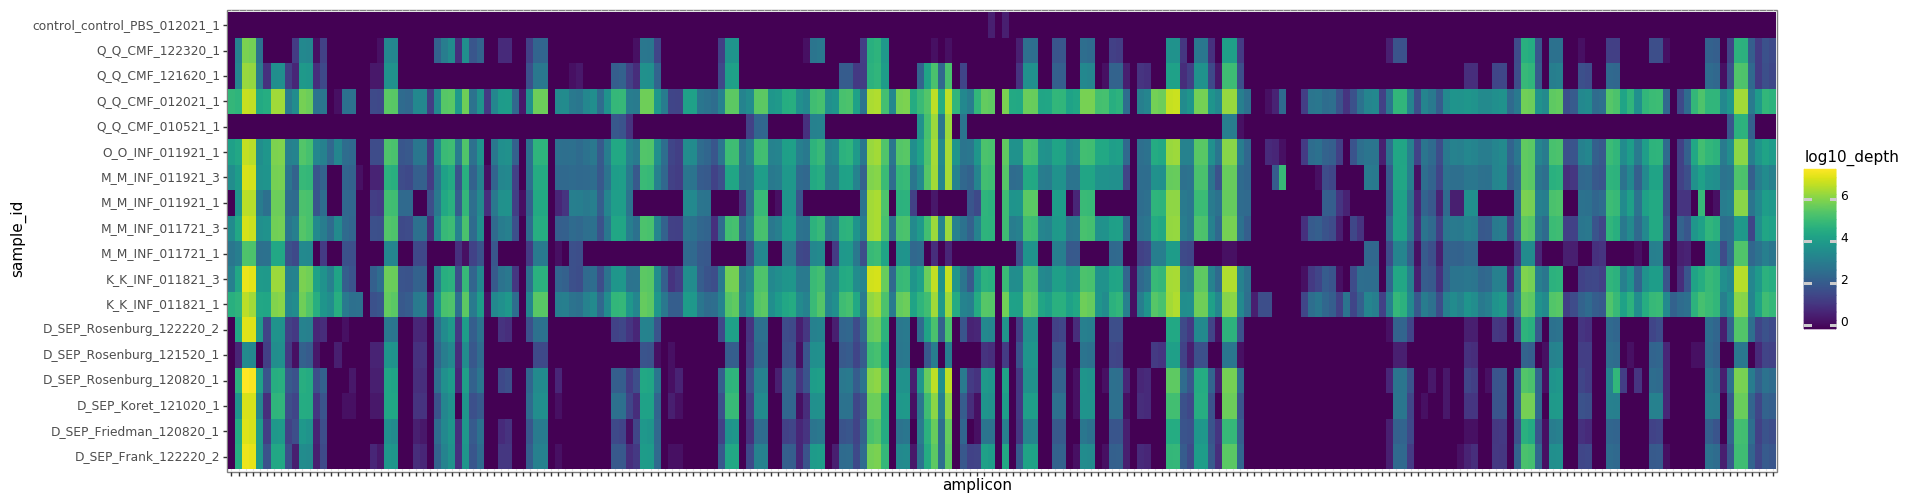

<ggplot: (303435709)>

In [71]:
(ggplot(amplicons_df[amplicons_df.batch == 1], aes(x='amplicon', y='sample_id', fill='log10_depth'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_blank(), figure_size=(20,6)))

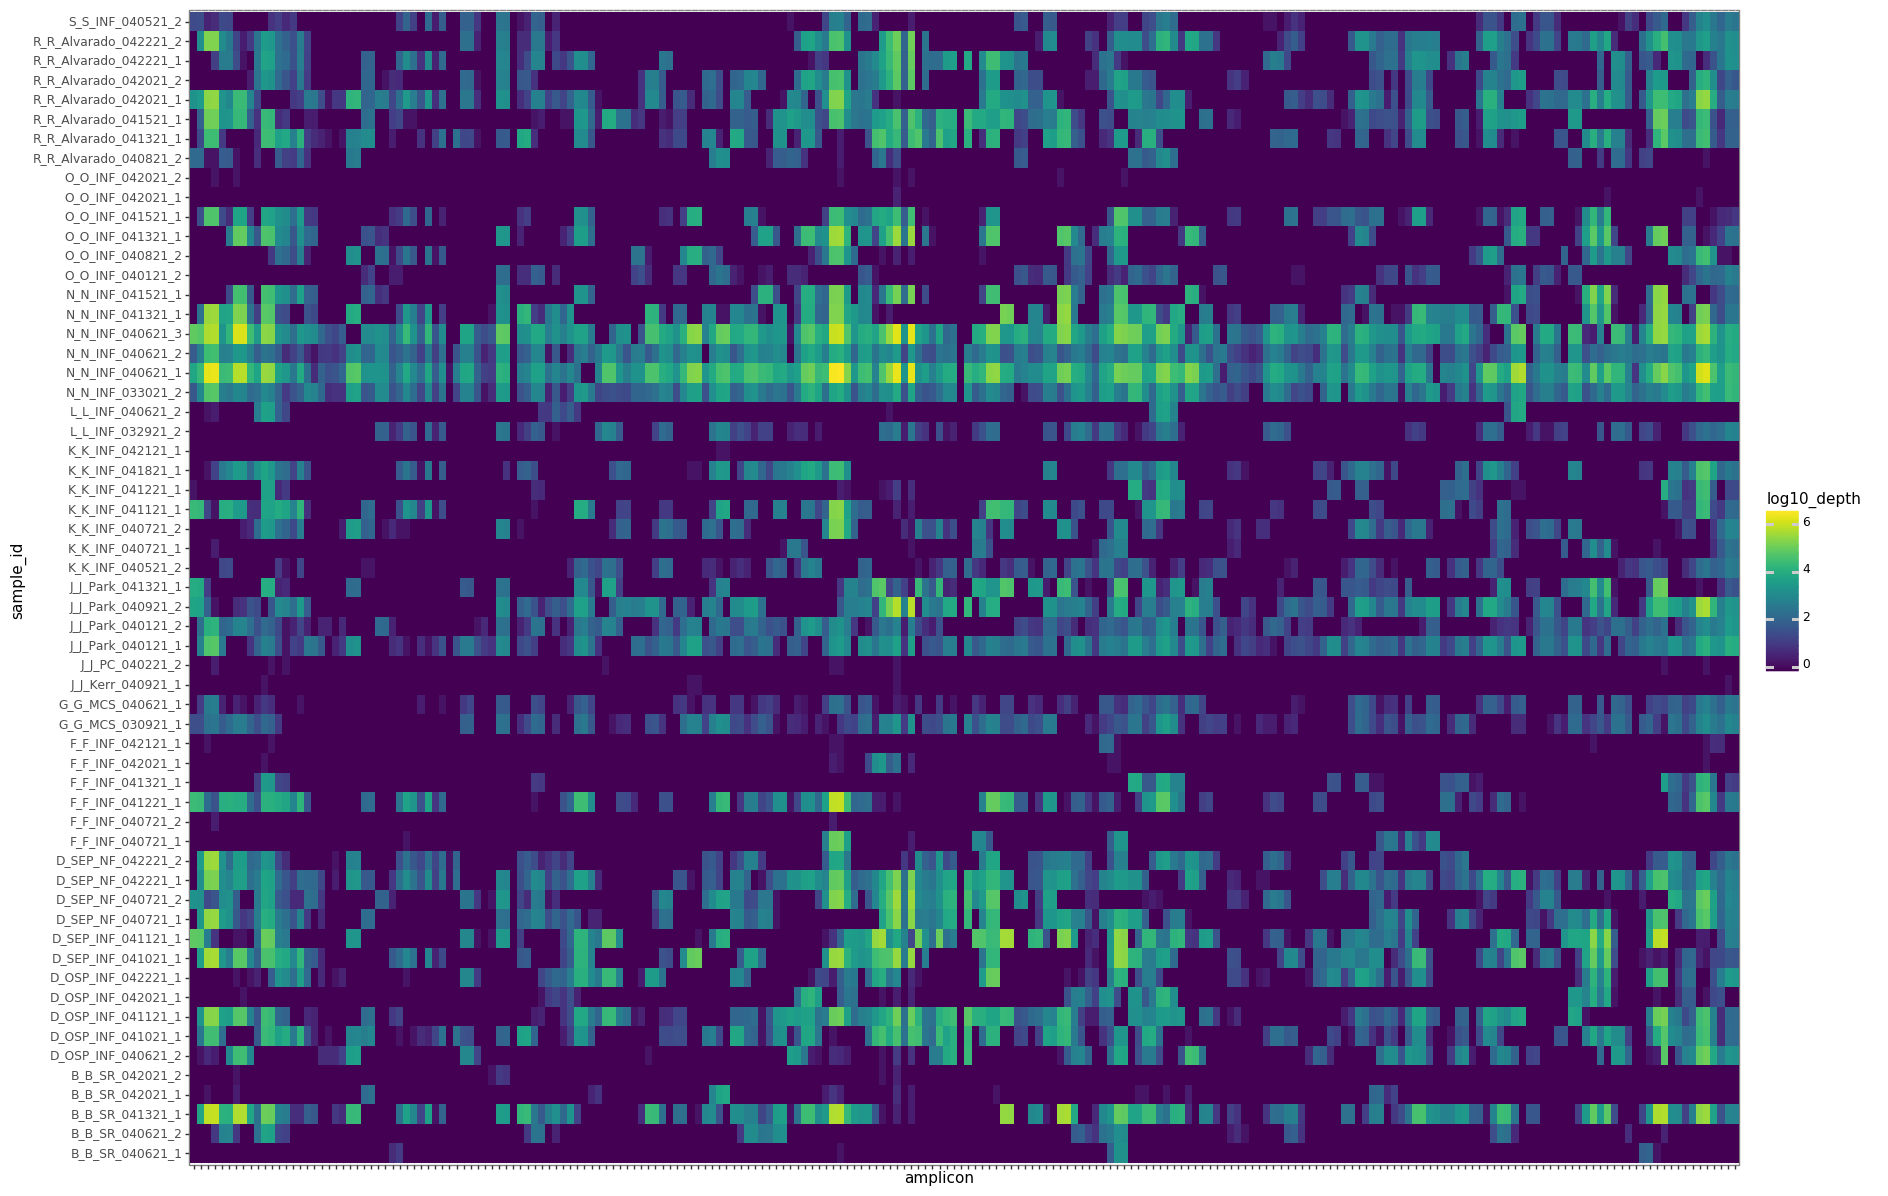

<ggplot: (301787021)>

In [68]:
(ggplot(amplicons_df[amplicons_df.batch == 2], aes(x='amplicon', y='sample_id', fill='log10_depth'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_blank(), figure_size=(20,15)))

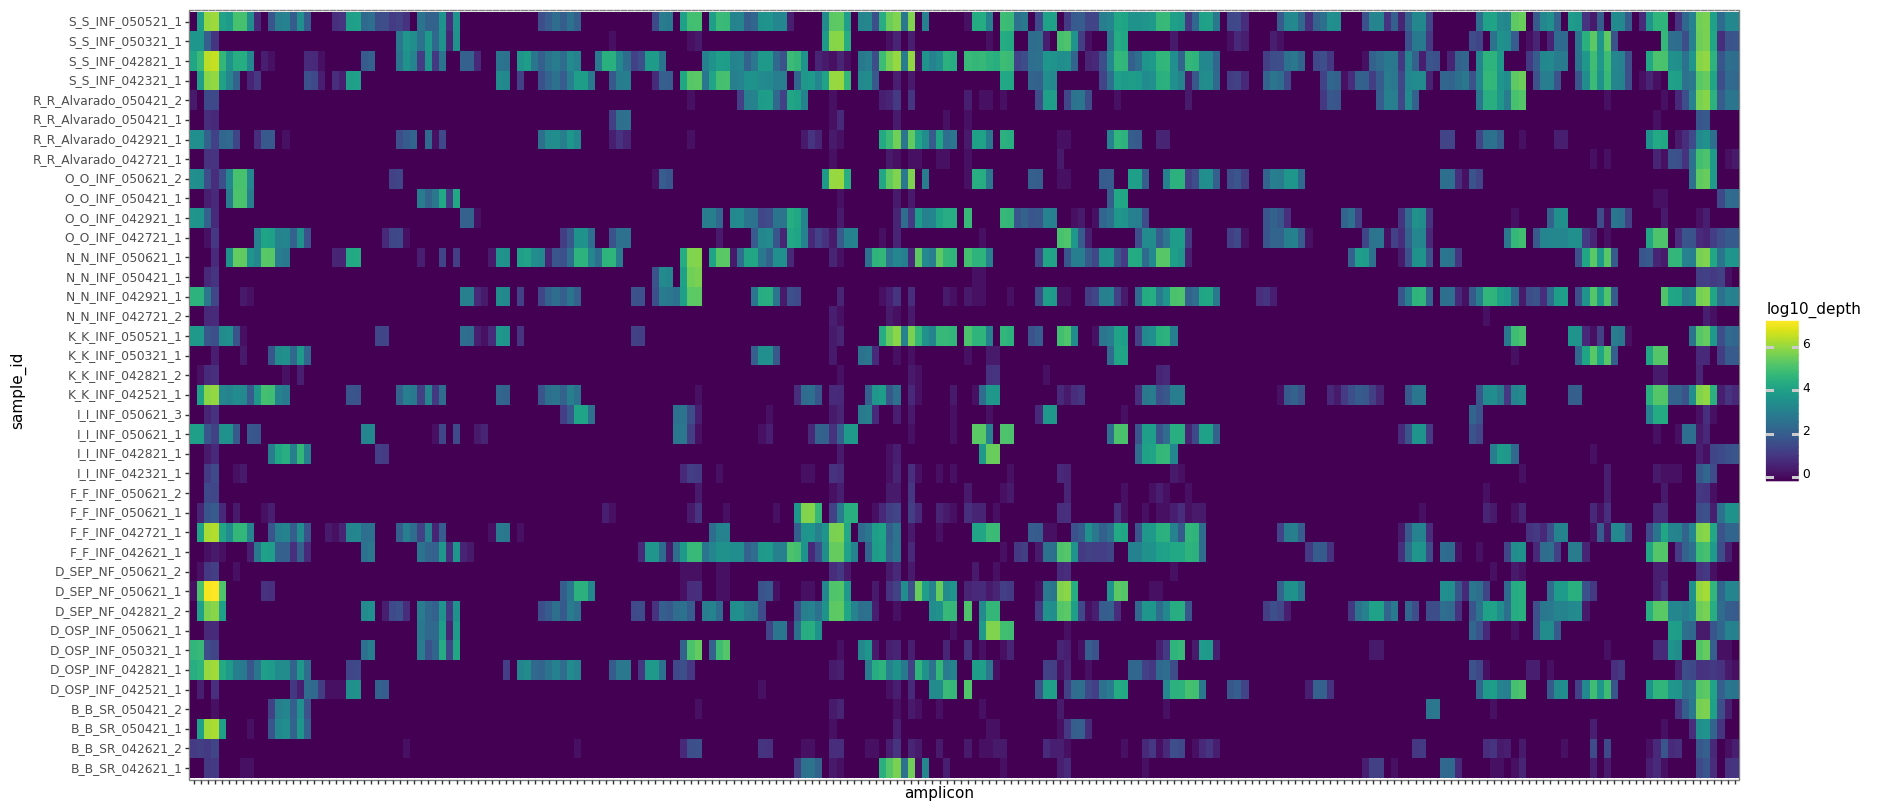

<ggplot: (301504197)>

In [69]:
(ggplot(amplicons_df[amplicons_df.batch == 3], aes(x='amplicon', y='sample_id', fill='log10_depth'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_blank(), figure_size=(20,10)))

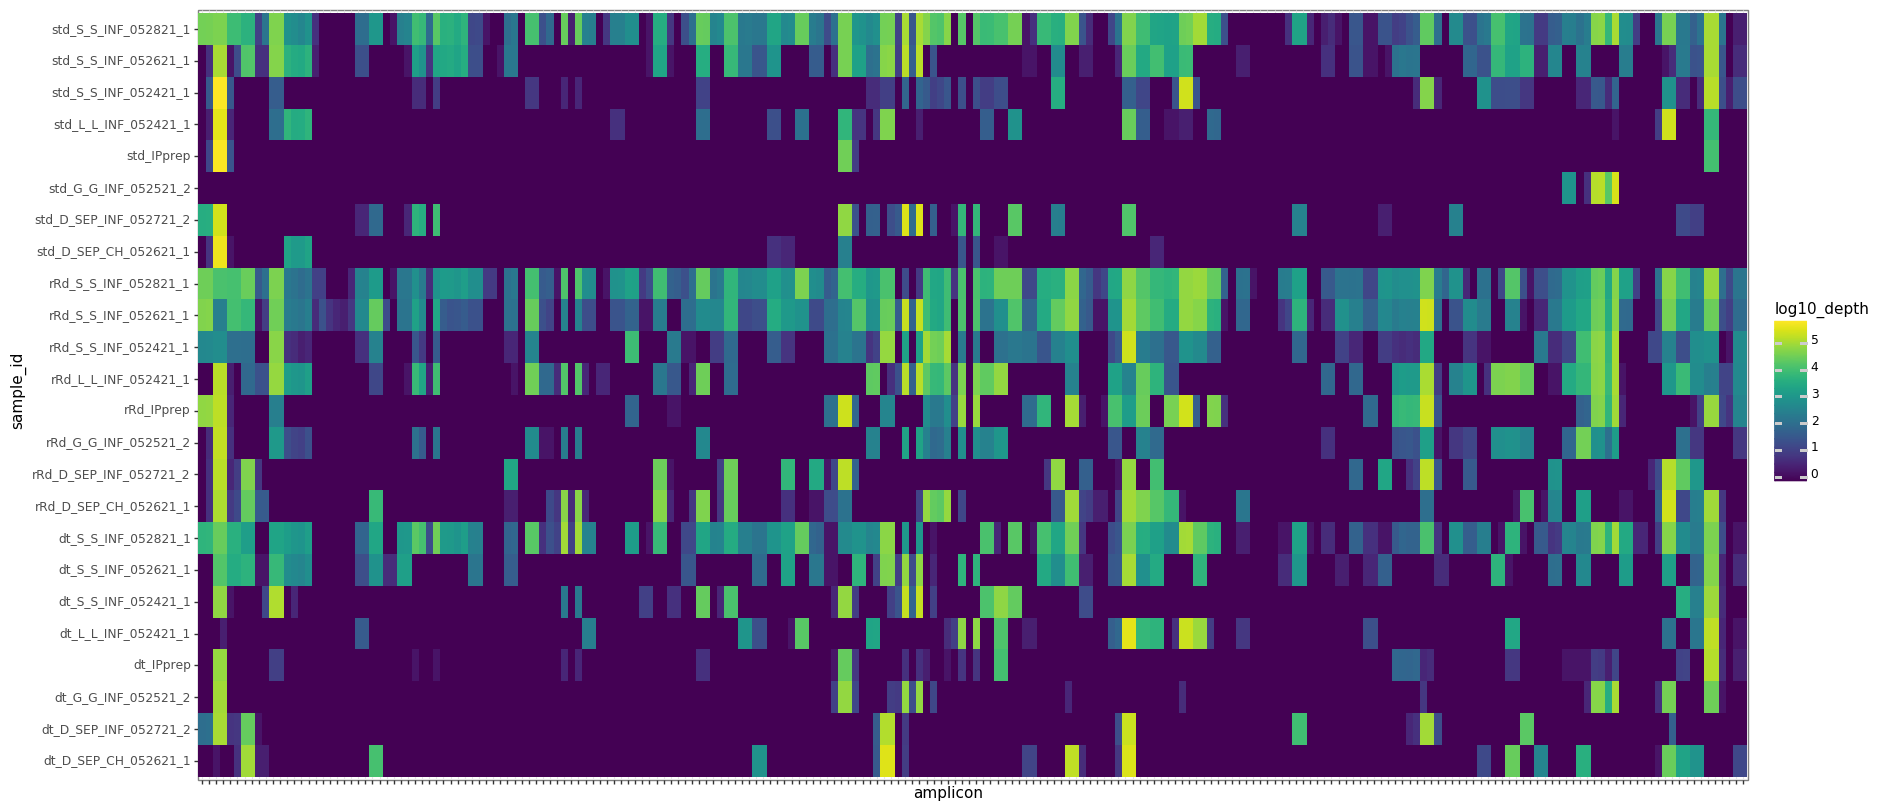

<ggplot: (303487193)>

In [74]:
(ggplot(amplicons_df[amplicons_df.batch == 4], aes(x='amplicon', y='sample_id', fill='log10_depth'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_blank(), figure_size=(20,10)))

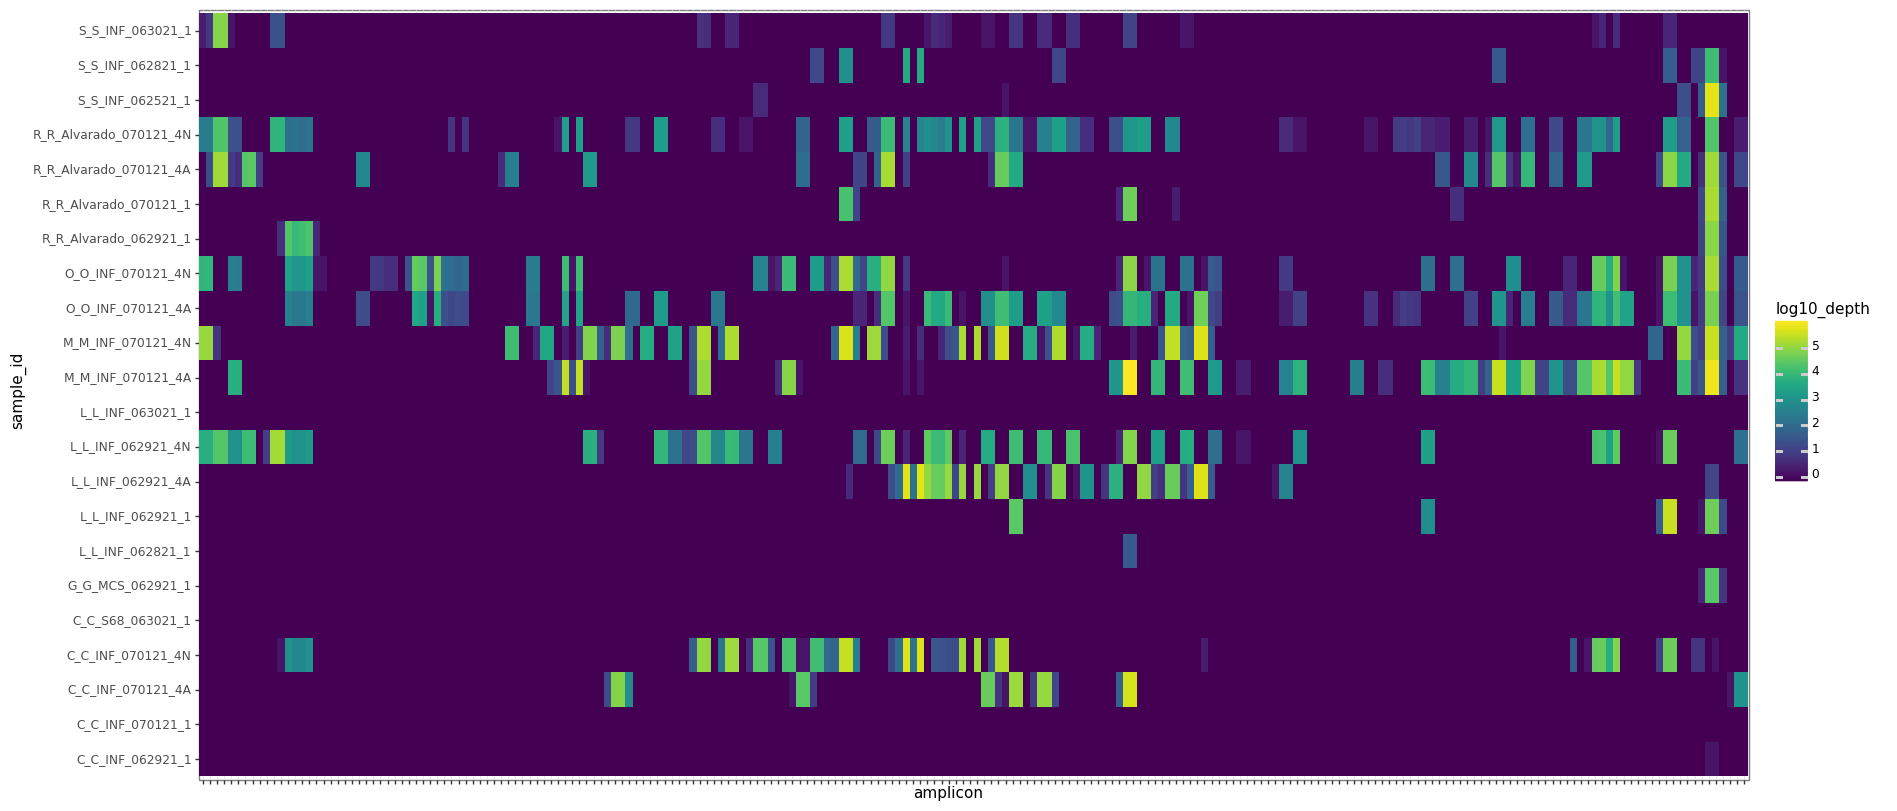

<ggplot: (304251017)>

In [79]:
(ggplot(amplicons_df[amplicons_df.batch == 5], aes(x='amplicon', y='sample_id', fill='log10_depth'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_blank(), figure_size=(20,10)))

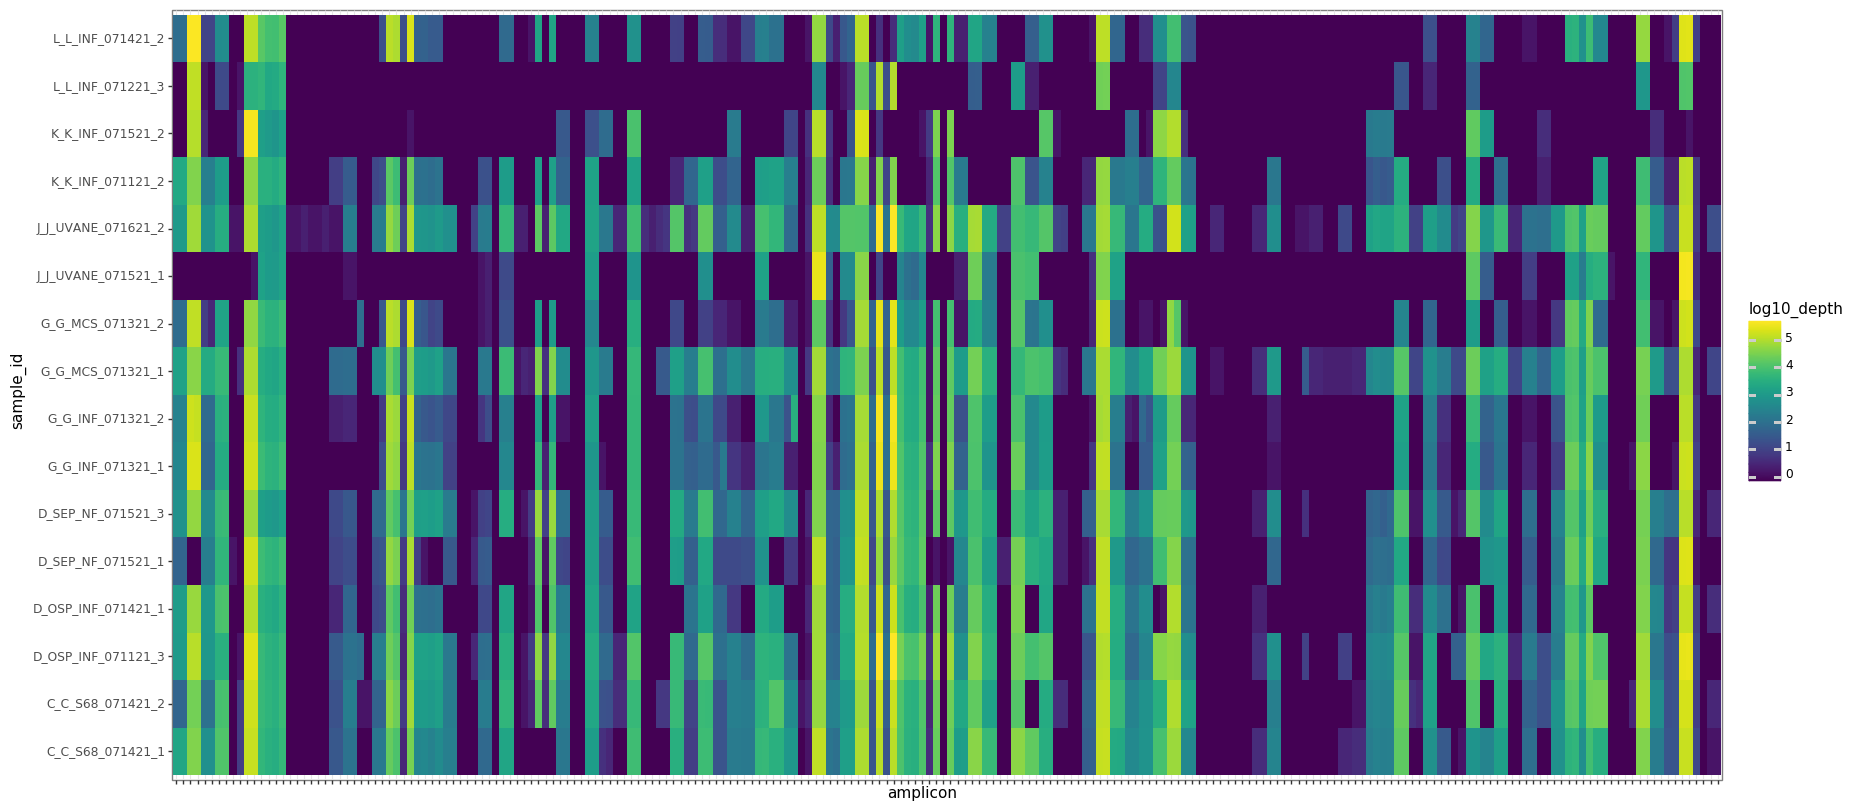

<ggplot: (305255125)>

In [152]:
(ggplot(amplicons_df[amplicons_df.batch == 6], aes(x='amplicon', y='sample_id', fill='log10_depth'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_blank(), figure_size=(20,10)))

# Load iVar data

In [392]:
# read in all files and combine into df

vars_samples = []
for batch in range(0,len(dirs)):
    for f in glob(f'{dirs[batch]}/variants_ivar/*.tsv'):
        s = os.path.basename(f).split('.')[0]
        df = pd.read_csv(f, sep='\t')
        df['sample_id'] = s
        vars_samples.append(df)
vars_samples = pd.concat(vars_samples)

In [393]:
vars_samples = vars_samples.rename(columns={'POS':'position', 'REF':'ref', 'ALT':'alt'})
vars_samples = vars_samples[['position', 'ref', 'alt', 'REF_DP', 'ALT_DP', 'ALT_FREQ', 'TOTAL_DP', 'PVAL', 'PASS', 'sample_id']]

In [394]:
vars_samples['snv_name'] = vars_samples.ref + vars_samples.position.astype('str') + vars_samples.alt

In [395]:
vars_samples.tail()

,position,ref,alt,REF_DP,ALT_DP,ALT_FREQ,TOTAL_DP,PVAL,PASS,sample_id,snv_name
115,28988,C,A,8,1,0.100000,10,0.073171,False,L_L_INF_071221_3,C28988A
116,28990,A,T,12,1,0.076923,13,0.102362,False,L_L_INF_071221_3,A28990T
117,28991,C,T,11,1,0.076923,13,0.095238,False,L_L_INF_071221_3,C28991T
118,28991,C,G,11,1,0.076923,13,0.095238,False,L_L_INF_071221_3,C28991G
119,29095,C,T,4610,3321,0.418526,7935,0.000000,True,L_L_INF_071221_3,C29095T


# Merge iVar and coverage data

In [396]:
# get coverage data even for sites where variants weren't called (outer merge)
vars_depth_samples = vars_samples.merge(depth_df[['position', 'sample_id', 'coverage']], 
                                        how='outer', on=['sample_id', 'position'])

# Look for specific variants

## Load GISAID data from COVID-CG

In [397]:
lineages_df = pd.read_json('/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_covidcg_080921.json')
lineages_df = lineages_df.rename(columns={'pos':'position', 'name':'variant'})
gisaid_snvs_df = lineages_df.groupby(['position', 'ref', 'alt', 'snv_name']).agg(lambda x: x.tolist()).reset_index()
gisaid_snvs_df['variant_count'] = gisaid_snvs_df.variant.apply(len)

# lineages of interest
voi = ['B.1','B.1.1.7', 'B.1.351', 
       'B.1.617', 'B.1.617.1', 'B.1.617.2', 'B.1.617.3',
       'AY.1', 'AY.2', 'AY.3', 'AY.3.1',
       'B.1.618', 'P.1', 'P.2', 'B.1.429', 'B.1.427']

# find snvs that are unique out of all lineages
var_unique_snvs = []
for i in voi:
    var_snvs = set(lineages_df[lineages_df.variant == i].snv_name)
    non_var_snvs = set(lineages_df[lineages_df.variant != i].snv_name)
    var_unique = var_snvs - non_var_snvs
    var_unique_df = lineages_df[lineages_df.snv_name.isin(var_unique)]
    
    # save
    var_unique_snvs.append(var_unique_df)
var_uniqueAll_snvs_df = pd.concat(var_unique_snvs)

In [398]:
# looking at all SNVs in B.1.617.2 and counting how many other variants each SNV is in (to find more unique ones/find other lineages)
# gisaid_snvs_df.variant = gisaid_snvs_df.variant.astype('str')
# delta1 = gisaid_snvs_df[gisaid_snvs_df.variant.str.contains('B.1.617.2')][['snv_name', 'variant', 'variant_count']]
# delta1[delta1.variant_count <= 7].variant.to_list()

In [399]:
# # something is wrong with the lineages file- should fraction be allowed to go above 1.0?
# lineages_df[lineages_df.variant == 'B.1.462']

In [400]:
# find snvs that are unique within just these lineages
vars_refs = lineages_df[lineages_df.variant.isin(voi)]
var_unique_snvs = []
for i in voi:
    var_snvs = set(lineages_df[lineages_df.variant == i].snv_name)
    non_var_snvs = set(vars_refs[vars_refs.variant != i].snv_name)
    var_unique = var_snvs - non_var_snvs
    var_unique_df = lineages_df[lineages_df.snv_name.isin(var_unique)]
    
    # save
    var_unique_snvs.append(var_unique_df)
var_unique_snvs_df = pd.concat(var_unique_snvs)

## Plot Delta

In [405]:
# make a table of all SNVs in delta lineages, listing which snvs are in which lineage

delta_lineages = ['B.1.617.2','AY.1', 'AY.2', 'AY.3', 'AY.3.1', 'B.1.617', 'B.1.617.1', 'B.1.617.3'] 
# potentially should include B.1.617, B.1.617.1, B.1.617.3 to be thorough at showing all SNVs

var_snvs = set(lineages_df[lineages_df.variant.isin(delta_lineages)].snv_name)
non_var_snvs = set(lineages_df[~lineages_df.variant.isin(delta_lineages)].snv_name)
delta_unique = var_snvs - non_var_snvs
delta_unique_df = lineages_df[lineages_df.snv_name.isin(delta_unique)]
delta_unique_df = delta_unique_df.sort_values(['variant', 'position'])

# group the table by snv, so duplicate snvs just get a list of variants
delta_unique_df = delta_unique_df.groupby(['snv_name', 'position', 'ref', 'alt']
                                         ).agg(lambda x: x.tolist()).reset_index().sort_values('variant')

# make the variant list into a nice-looking string for plotting
delta_unique_df.variant = delta_unique_df.variant.astype('str')
delta_unique_df.variant = delta_unique_df.variant.str.replace('[', '')
delta_unique_df.variant = delta_unique_df.variant.str.replace(']', '')
delta_unique_df.variant = delta_unique_df.variant.str.replace(r'\'', '')
delta_unique_df = delta_unique_df[['snv_name', 'position', 'ref', 'alt', 'variant']]

In [406]:
# get variants and coverage in samples at the positions of unique delta SNVS 
delta_unique_samples_df = vars_depth_samples[vars_depth_samples.position.isin(delta_unique_df.position)]

# add in the info about each SNV (which variants it is in)
delta_unique_samples_df = delta_unique_samples_df.merge(delta_unique_df, how='left',
                                                        on='position',
                                                        suffixes=('_samp', '_var'))

# filter out rows where alt is not NaN and doesn't match to the alt in the variant
# these are interesting though, so investigate them separately
delta_unique_samples_df = delta_unique_samples_df[~((~delta_unique_samples_df.alt_samp.isna()) &
                                                    (delta_unique_samples_df.alt_samp != delta_unique_samples_df.alt_var)
                                                   )]

In [407]:
delta_unique_samples_df.head()

,position,ref_samp,alt_samp,REF_DP,ALT_DP,ALT_FREQ,TOTAL_DP,PVAL,PASS,sample_id,snv_name_samp,coverage,snv_name_var,ref_var,alt_var,variant
0,28461.0,A,G,0,1,1.000000,1,1.000000e+00,False,M_M_INF_011921_1,A28461G,1,A28461G,A,G,"AY.1, AY.2, AY.3, AY.3.1, B.1.617.2"
10,28881.0,G,T,2,7,0.777778,9,1.131220e-03,True,D_OSP_INF_041121_1,G28881T,10,G28881T,G,T,"AY.1, AY.2, AY.3, AY.3.1, B.1.617.1, B.1.617.2..."
11,28916.0,G,T,5,19,0.791667,24,3.570790e-10,True,D_OSP_INF_041121_1,G28916T,30,G28916T,G,T,"AY.1, AY.3.1"
14,210.0,G,T,0,617,0.998382,618,0.000000e+00,True,R_R_Alvarado_042021_1,G210T,655,G210T,G,T,"AY.1, AY.2, AY.3, AY.3.1, B.1.617.1, B.1.617.2..."
15,11332.0,A,G,2,948,0.996845,951,0.000000e+00,True,R_R_Alvarado_042021_1,A11332G,992,A11332G,A,G,"AY.1, AY.3.1"


/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less


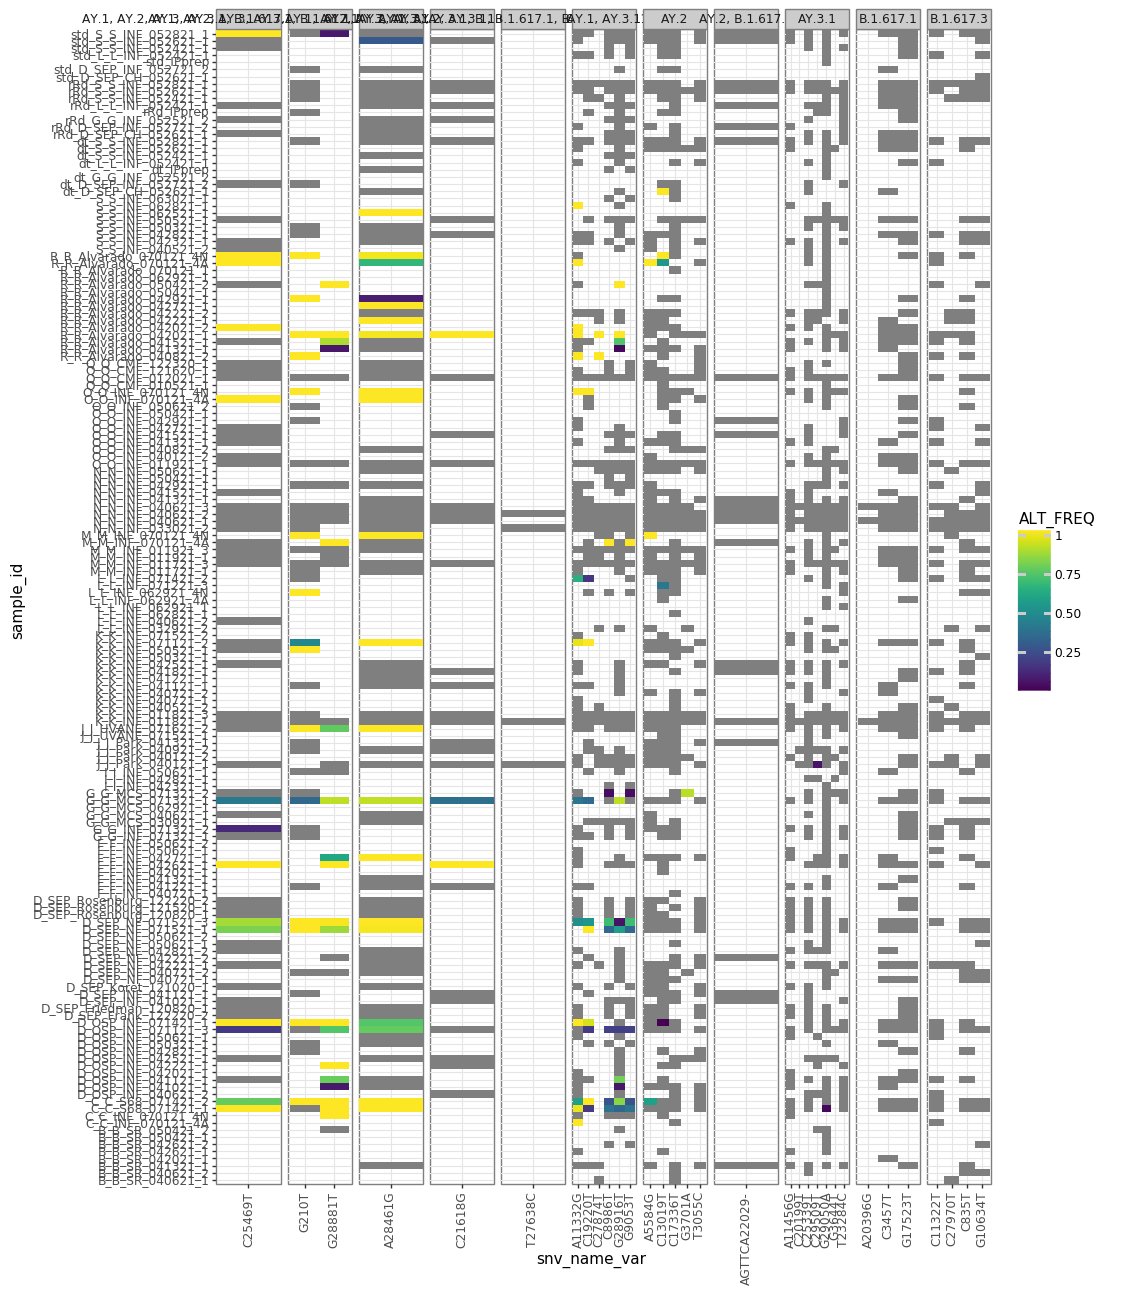

<ggplot: (312132405)>

In [408]:
delta_unique_samples_df_filt = delta_unique_samples_df[(delta_unique_samples_df.coverage >= 10)]
(ggplot(delta_unique_samples_df_filt, aes(x='snv_name_var', y='sample_id', fill='ALT_FREQ'))+
geom_tile()+
theme_bw()+
theme(figure_size=(10, 15), axis_text_x=element_text(angle=90, hjust=1.1))+
facet_wrap('~ variant', scales='free_x', nrow=1)
)

## Look for SNVS from GISAID in samples

In [91]:
# variant = 'B.1.429'
# var_snvs = var_unique_snvs_df[var_unique_snvs_df.variant == variant]['snv_name']
# var_sample_df = vars_samples[(vars_samples.snv_name.isin(var_snvs))].copy() # drop sample x positions without coverage
# var_sample_df.position = var_sample_df.position.astype('category')
# var_sample_df = var_sample_df[var_sample_df.TOTAL_DP > 10]

# # filter for samples that have at least 2 of the SNVs
# var_sample_df_counts = var_sample_df.groupby('sample_id').agg(counts=('position', 'count')).reset_index()
# keep_samples = var_sample_df_counts[var_sample_df_counts.counts >=1].sample_id
# var_sample_df = var_sample_df[var_sample_df.sample_id.isin(keep_samples)]

# plt = (ggplot(var_sample_df, aes(x='snv_name', y='sample_id', fill='ALT_FREQ'))+
# geom_tile()+
# #geom_text(aes(label='coverage'), size=9)+
# theme_classic()+
# theme(figure_size=(5, 10), axis_text_x=element_text(angle = 45, hjust = 1)))
# #facet_wrap('~ variant', scales='free_x', ncol=5))
# display(plt)

# # gray means there was coverage but no alternate freq
# # white means there was no coverage and no alternate freq
# #ggsave(plt, '/Users/rosekantor/data/wbe_scv/heatmap_b1.1.7.png')

In [161]:
variant = 'B.1.1.7'
var_snvs = var_unique_snvs_df[var_unique_snvs_df.variant == variant]['snv_name']
var_sample_df = vars_samples[(vars_samples.snv_name.isin(var_snvs))].copy() # drop sample x positions without coverage
var_sample_df.position = var_sample_df.position.astype('category')
var_sample_df = var_sample_df[var_sample_df.TOTAL_DP > 10]

# filter for samples that have at least 2 of the SNVs
var_sample_df_counts = var_sample_df.groupby('sample_id').agg(counts=('position', 'count')).reset_index()
keep_samples = var_sample_df_counts[var_sample_df_counts.counts >=2].sample_id
var_sample_df = var_sample_df[var_sample_df.sample_id.isin(keep_samples)]

var_sample_df = var_sample_df.merge(stats_df, how='left', on='sample_id')

In [162]:
# keep just the rRd samples from batch 4
var_sample_df = var_sample_df[((var_sample_df.batch == 4) & (var_sample_df.sample_id.str.startswith('rRd'))) |
                              (var_sample_df.batch != 4)]

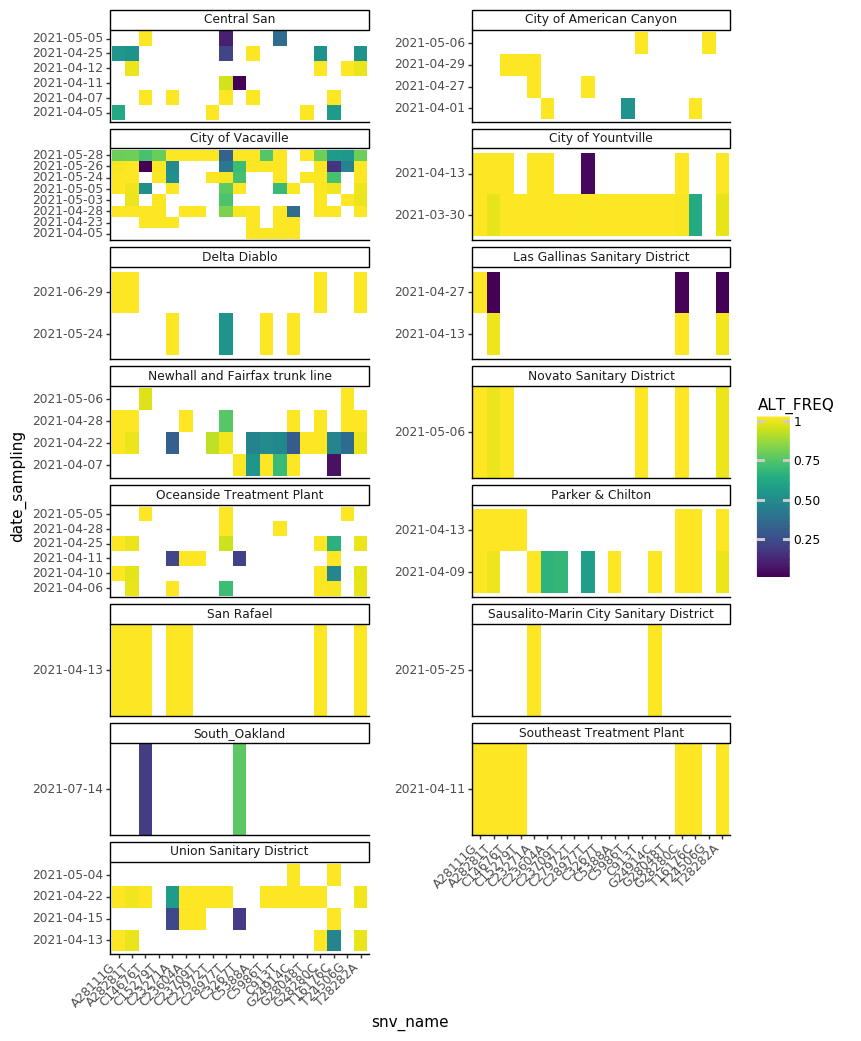

<ggplot: (305773713)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 8 x 12 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/sequencing/b117_heatmap_June2021.png


In [163]:
plt = (ggplot(var_sample_df, aes(x='snv_name', y='date_sampling', fill='ALT_FREQ'))+
geom_tile()+
#geom_text(aes(label='coverage'), size=9)+
theme_classic()+
theme(figure_size=(8, 12), axis_text_x=element_text(angle=45, hjust=1), subplots_adjust={'wspace': 0.4})+
      #legend_position='bottom', legend_direction='horizontal')+
facet_wrap('~ site_full_name', scales='free_y', ncol=2))
 #facet_grid('site_full_name ~', scales='free_y', space='free_y')) #not yet implemented in plotnine

display(plt)
ggsave(plt, '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/sequencing/b117_heatmap_June2021.png')

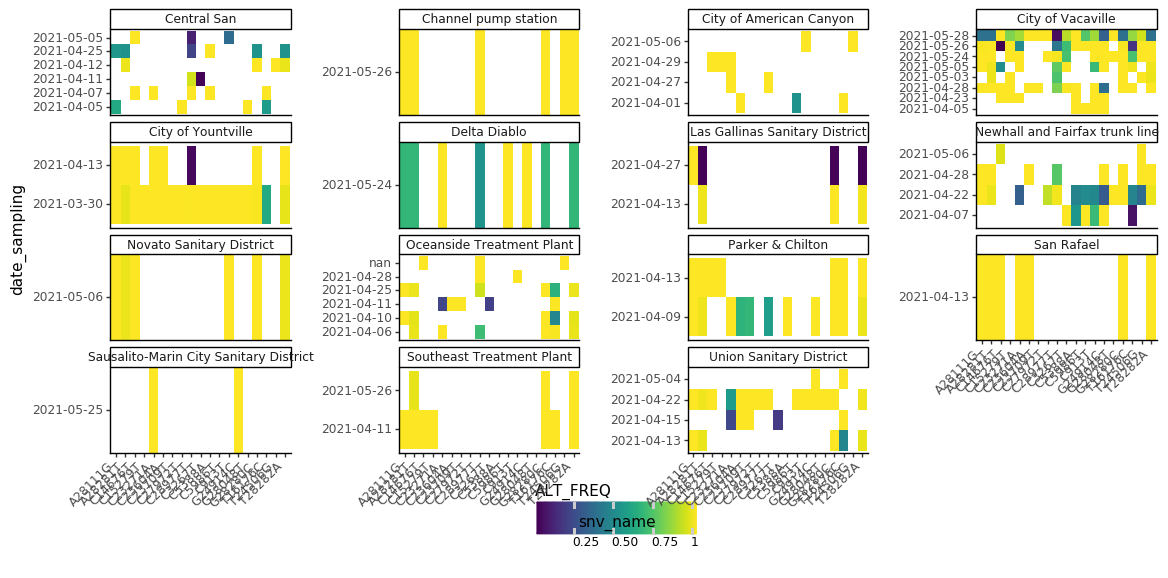

<ggplot: (307573453)>

In [613]:
plt = (ggplot(var_sample_df, aes(x='snv_name', y='date_sampling', fill='ALT_FREQ'))+
geom_tile()+
#geom_text(aes(label='coverage'), size=9)+
theme_classic()+
theme(figure_size=(13.5, 5.5), axis_text_x=element_text(angle=45, hjust=1), subplots_adjust={'wspace': 0.6},
      legend_position='bottom', legend_direction='horizontal')+
 facet_wrap('~ site_full_name', scales='free_y', ncol=4))
display(plt)
# gray means there was coverage but no alternate freq
# white means there was no coverage and no alternate freq
# ggsave(plt, '/Users/rosekantor/data/wbe_scv/qb3_may2021/figures/heatmap_CA_variants.png')

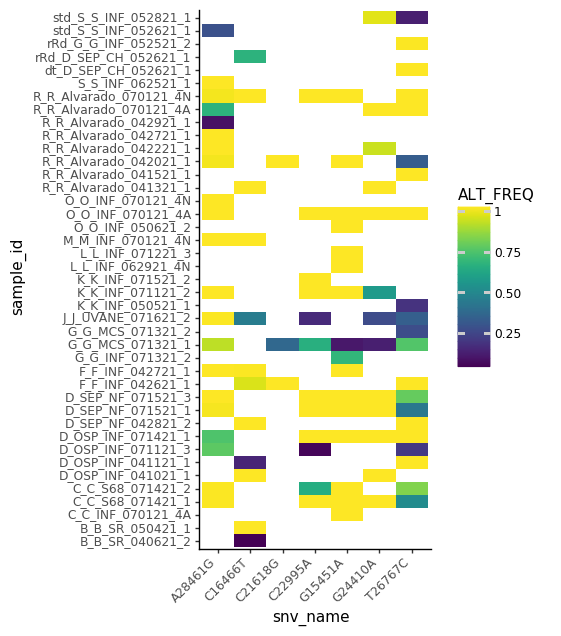

<ggplot: (305253933)>

In [165]:
variant = 'B.1.617.2'
var_snvs = var_unique_snvs_df[var_unique_snvs_df.variant == variant]['snv_name']
var_sample_df = vars_samples[(vars_samples.snv_name.isin(var_snvs))].copy() # drop sample x positions without coverage
var_sample_df.position = var_sample_df.position.astype('category')
var_sample_df = var_sample_df[var_sample_df.TOTAL_DP > 5]

# filter for samples that have at least 2 of the SNVs
var_sample_df_counts = var_sample_df.groupby('sample_id').agg(counts=('position', 'count')).reset_index()
keep_samples = var_sample_df_counts[var_sample_df_counts.counts >=1].sample_id
var_sample_df = var_sample_df[var_sample_df.sample_id.isin(keep_samples)]

plt = (ggplot(var_sample_df, aes(x='snv_name', y='sample_id', fill='ALT_FREQ'))+
geom_tile()+
#geom_text(aes(label='coverage'), size=9)+
theme_classic()+
theme(figure_size=(3, 7), axis_text_x=element_text(angle = 45, hjust = 1)))
#facet_wrap('~ variant', scales='free_x', ncol=5))
display(plt)
# gray means there was coverage but no alternate freq
# white means there was no coverage and no alternate freq
#ggsave(plt, '/Users/rosekantor/data/wbe_scv/heatmap_b1.1.7.png')

# Look for specific mutations

In [210]:
lineages_df = pd.read_json('/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_covidcg_080921.json')
lineages_df = lineages_df.rename(columns={'pos':'position', 'name':'variant'})

# lineages of interest
voi = ['B.1','B.1.1.7', 'B.1.351', 'B.1.617', 'B.1.617.1', 'B.1.617.2', 'B.1.617.3' 'B.1.618', 'P.1', 'P.2', 'B.1.429', 'B.1.427']
vars_refs = lineages_df[lineages_df.variant.isin(voi)]

In [204]:
# Delta
# vars_refs[vars_refs.variant == 'B.1.617.2'].sort_values('position')

In [168]:
moi_df = pd.DataFrame({'snv_name':['T22917G','G23012A', 'G23012C', 'A23063T', 'A22812C', 'C22995A'],
                       'position':[22917, 23012, 23012, 23063, 22812, 22995],
                       'aa_change':['L452R', 'E484K', 'E484Q', 'N501Y', 'K417T', 'T478K']})

In [169]:
var_lists = []
for r in moi_df.itertuples():
    vars_with_snv = lineages_df[lineages_df.snv_name == r.snv_name]['variant'].to_list()
    var_lists.append(vars_with_snv)
moi_df['variants'] = var_lists
moi_df['number_of_variants'] = moi_df['variants'].apply(len)

In [170]:
moi_df

,snv_name,position,aa_change,variants,number_of_variants
0,T22917G,22917,L452R,"[A.2.5, A.2.5.1, A.2.5.2, A.27, AY.1, AY.2, B....",17
1,G23012A,23012,E484K,"[AT.1, AV.1, B.1.1.318, B.1.1.345, B.1.1.523, ...",23
2,G23012C,23012,E484Q,"[B.1.617, B.1.617.1, B.1.617.3]",3
3,A23063T,23063,N501Y,"[A.27, A.29, AP.1, B.1.1.136, B.1.1.7, B.1.324...",17
4,A22812C,22812,K417T,"[P.1, P.1.1, P.1.2]",3
5,C22995A,22995,T478K,"[AY.1, AY.2, B.1.1.519, B.1.214.3, B.1.617.2]",5


In [171]:
# get info on this set of variants in our samples

mois_samples = vars_samples[(vars_samples.snv_name.isin(moi_df.snv_name)) & (vars_samples.TOTAL_DP > 10)][['snv_name','sample_id', 'ALT_FREQ']]
mois_samples_pivot = mois_samples.pivot(index='sample_id', columns='snv_name', values='ALT_FREQ').reset_index()

stats_mois_df = stats_df.merge(mois_samples_pivot, on='sample_id', how='left')

In [172]:
vars_samples[vars_samples.snv_name == 'A22812C']

,position,ref,alt,REF_DP,ALT_DP,ALT_FREQ,TOTAL_DP,PVAL,PASS,sample_id,snv_name
139,22812,A,C,0,20,1.0,20,3.715690e-12,True,B_B_SR_042621_1,A22812C
219,22812,A,C,0,2160,1.0,2160,0.000000e+00,True,rRd_D_SEP_INF_052721_2,A22812C


In [173]:
## check if there was depth at those positions but no mutation
# get coverage at those positions, merge onto the main stats_df dataframe

moi_depth_df = depth_df[depth_df.position.isin(moi_df.position)][['sample_id', 'position', 'coverage']]
moi_depth_pivot = moi_depth_df.pivot(index='sample_id', columns='position', values='coverage').reset_index()

stats_mois_df = stats_mois_df.merge(moi_depth_pivot, on='sample_id', how='left')

# change the snv_name values to 0 if there was depth > 10x but no mutation
for r in moi_df.itertuples():
    if r.snv_name in stats_mois_df.columns:
        stats_mois_df.loc[(stats_mois_df[r.position] > 10) & (stats_mois_df[r.snv_name].isna()), r.snv_name] = 0
        


In [174]:
stats_mois_df.head()

,sample_id,original_id,fragment_analyzer_band,merge_id,batch,treatment,sample_code,rep,Sample,date_sampling,...,A22812C,A23063T,C22995A,G23012A,T22917G,22812,22917,22995,23012,23063
0,control_control_PBS_012021_1,control_control_PBS_12021_1,no band,control_control_PBS_012021_1,1,std,control_control_PBS,1,NaN,2021-01-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D_SEP_Frank_122220_2,D_SEP_Frank_122220_2,ok,D_SEP_Frank_122220_2,1,std,D_SEP_Frank,2,D_SEP_Frank_122220_2,2020-12-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D_SEP_Friedman_120820_1,D_SEP_Friedman_120820_1,ok,D_SEP_Friedman_120820_1,1,std,D_SEP_Friedman,1,D_SEP_Friedman_120820_1,2020-12-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D_SEP_Koret_121020_1,D_SEP_Koret_121020_1,ok,D_SEP_Koret_121020_1,1,std,D_SEP_Koret,1,D_SEP_Koret_121020_1,2020-12-10,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.0
4,D_SEP_Rosenburg_120820_1,D_SEP_Rosenburg_120820_1,good,D_SEP_Rosenburg_120820_1,1,std,D_SEP_Rosenburg,1,D_SEP_Rosenburg_120820_1,2020-12-08,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.0


In [175]:
# prepare data for nicely labeled heatmap

# keep only the columns that we need for the heatmap (so that we can pivot)
keep_list = moi_df.snv_name.to_list()
keep_list.append('sample_id')
keep_list = set(keep_list).intersection(set(stats_mois_df.columns))

stats_mois_subset = stats_mois_df[keep_list]

# drop rows where there is no information (all snvs had no coverage in that sample)
stats_mois_subset = stats_mois_subset.dropna(thresh=2) # rows with at least 2 non-NA values (one is 'sample_id', the other is a snv_name)
# this kept 50 of 116 samples

# melt for ggplot
stats_mois_subset = stats_mois_subset.melt(id_vars='sample_id', var_name='snv_name', value_name='alt_freq')
# round data for nicer printing
stats_mois_subset.alt_freq = stats_mois_subset.alt_freq.round(2)

# merge with stats_df to get site names and sample dates
stats_mois_subset = stats_mois_subset.merge(stats_df, how='left', on='sample_id')

In [176]:
# drop samples without date (should actually fix the date but will do that later)
# currently the only one being dropped is: D_OSP_INF_042221_1
stats_mois_subset = stats_mois_subset[~stats_mois_subset.date_sampling.isna()]

In [177]:
stats_mois_subset.date_sampling = pd.to_datetime(stats_mois_subset.date_sampling)
stats_mois_subset['pretty_date'] = stats_mois_subset.date_sampling.apply(lambda x: x.strftime('%m/%d/%y'))
stats_mois_subset['pretty_date_rep'] = stats_mois_subset['pretty_date'] + ' rep ' + stats_mois_subset['rep']

In [178]:
# add all the info about snvs
stats_mois_subset = stats_mois_subset.merge(moi_df, how='left', on='snv_name')

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less


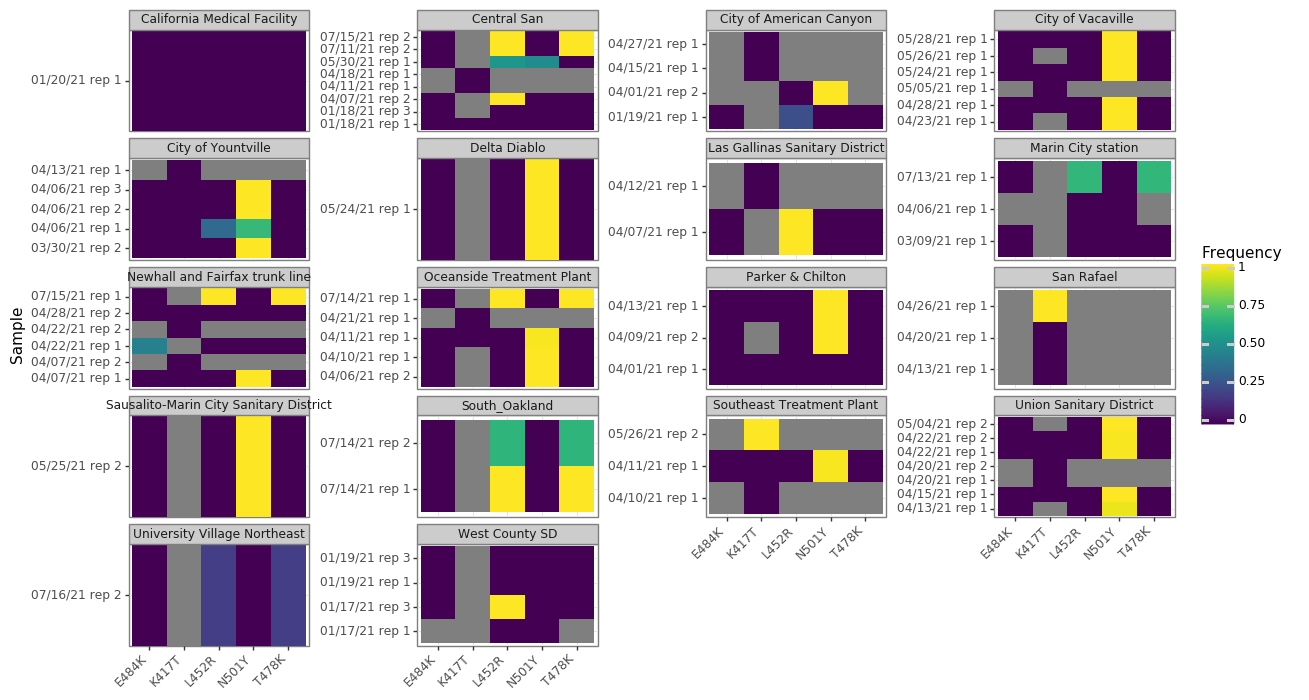

<ggplot: (305082265)>

In [190]:
# make heatmap
(ggplot(stats_mois_subset, aes(x='aa_change', y='pretty_date_rep', fill='alt_freq'))+
 geom_tile()+
 #geom_text(aes(label = 'alt_freq'), size=9, color='white')+
 ylab('Sample')+
 xlab('')+
 labs(fill='Frequency')+
 facet_wrap('~ site_full_name', scales='free_y', ncol=4)+
 theme_bw()+
 theme(figure_size=(13.5, 8), axis_text_x=element_text(angle=45, hjust=1), subplots_adjust={'wspace': 0.6}#,
     ) #legend_position='bottom', legend_direction='horizontal'
 )


/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less


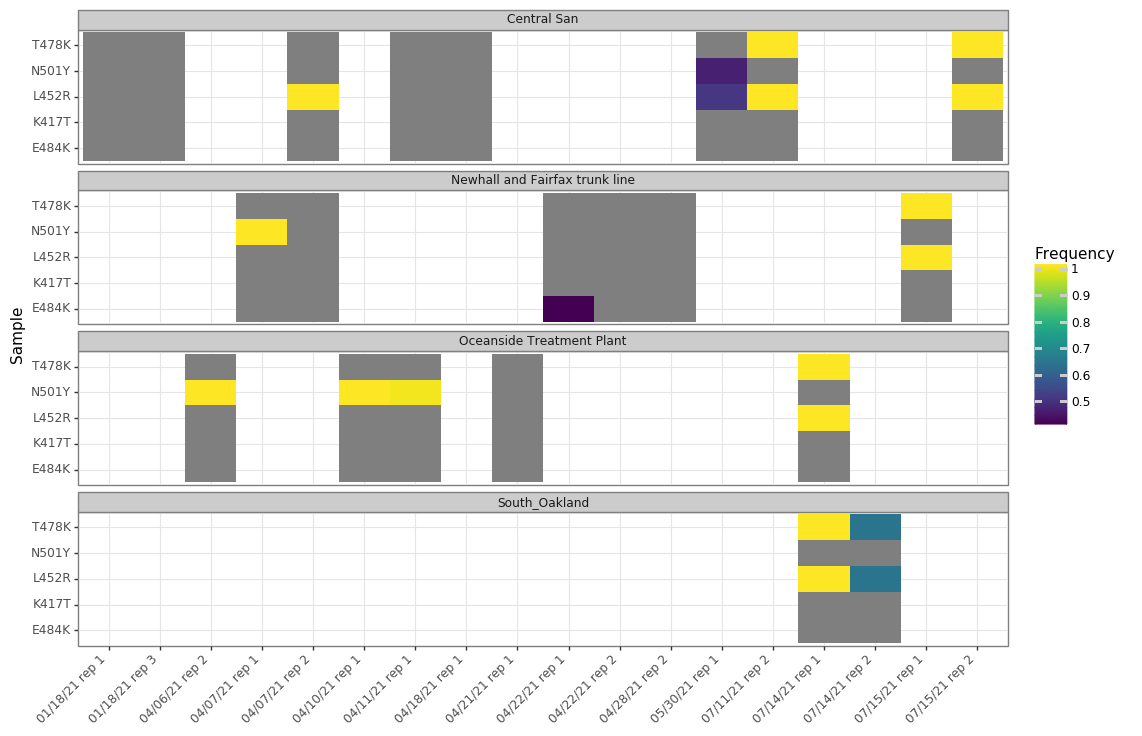

<ggplot: (305174353)>

In [202]:
# make heatmap
recent_data = ['Central San', 'Marin City Station', 'Oceanside Treatment Plant', 'South_Oakland', 'Newhall and Fairfax trunk line']
stats_mois_subset.loc[stats_mois_subset.alt_freq == 0, 'alt_freq'] = np.nan
(ggplot(stats_mois_subset[stats_mois_subset.site_full_name.isin(recent_data)], aes(y='aa_change', x='pretty_date_rep', fill='alt_freq'))+
 geom_tile()+
 #geom_text(aes(label = 'alt_freq'), size=9, color='white')+
 ylab('Sample')+
 xlab('')+
 labs(fill='Frequency')+
 theme_bw()+
 theme(figure_size=(12, 8), axis_text_x=element_text(angle=45, hjust=1), subplots_adjust={'wspace': 0.4})+
      #legend_position='bottom', legend_direction='horizontal')+
    facet_wrap('~ site_full_name', scales='free_y', ncol=1)
 )

In [203]:
stats_mois_subset[(stats_mois_subset.site_full_name.isin(recent_data)) &
                  (stats_mois_subset.alt_freq > 0)][['site_full_name', 'pretty_date_rep', 'sample_id', 'aa_change', 'alt_freq']]

,site_full_name,pretty_date_rep,sample_id,aa_change,alt_freq
18,Newhall and Fairfax trunk line,04/07/21 rep 1,D_SEP_NF_040721_1,N501Y,1.00
20,Oceanside Treatment Plant,04/06/21 rep 2,D_OSP_INF_040621_2,N501Y,1.00
24,Oceanside Treatment Plant,04/10/21 rep 1,D_OSP_INF_041021_1,N501Y,1.00
25,Oceanside Treatment Plant,04/11/21 rep 1,D_OSP_INF_041121_1,N501Y,0.99
50,Central San,05/30/21 rep 1,dt_IPprep,N501Y,1.00
55,Central San,05/30/21 rep 1,rRd_IPprep,N501Y,0.48
86,Central San,04/07/21 rep 2,K_K_INF_040721_2,L452R,1.00
126,Central San,05/30/21 rep 1,rRd_IPprep,L452R,0.52
133,South_Oakland,07/14/21 rep 1,C_C_S68_071421_1,L452R,1.00
134,South_Oakland,07/14/21 rep 2,C_C_S68_071421_2,L452R,0.65


In [418]:
stats_mois_subset[stats_mois_subset.site_full_name == 'Central San'][['merge_id', 'sample_id', 'aa_change', 'alt_freq']]

,merge_id,sample_id,aa_change,alt_freq
0,K_K_INF_011821_1,K_K_INF_011821_1,N501Y,0.00
1,K_K_INF_011821_3,K_K_INF_011821_3,N501Y,0.00
15,K_K_INF_040721_2,K_K_INF_040721_2,N501Y,0.00
32,K_K_INF_041121_1,K_K_INF_041121_1,N501Y,NaN
42,K_K_INF_041821_1,K_K_INF_041821_1,N501Y,NaN
50,K_K_INF_053021_1,dt_IPprep,N501Y,1.00
54,K_K_INF_053021_1,rRd_IPprep,N501Y,0.48
61,K_K_INF_011821_1,K_K_INF_011821_1,E484K,0.00
62,K_K_INF_011821_3,K_K_INF_011821_3,E484K,0.00
76,K_K_INF_040721_2,K_K_INF_040721_2,E484K,0.00


# GATK

## S_S_INF samples from batch 4

In [602]:
gatk_files = ['rRd_S_S_INF_052421_1.gatk.vcf', 'rRd_S_S_INF_052621_1.gatk.vcf', 'rRd_S_S_INF_052821_1.gatk_split.vcf']

gatk_df = []
for f in gatk_files:
    df = pd.read_csv(f'{datadir4}/variants_mutect2/{f}', sep='\t', comment='#',
                      names=['CHROM',
                             'position',
                             'ID',
                             'REF',
                             'ALT',
                             'QUAL',
                             'FILTER',
                             'INFO',
                             'FORMAT',
                             'sample_info'])

    df['sample_id'] = f.split('.')[0]
    gatk_df.append(df)
gatk_df = pd.concat(gatk_df)
gatk_df = gatk_df[['sample_id','position','REF','ALT','INFO','sample_info']]

In [603]:
gatk_df[['GT','AD','AF','DP']] = gatk_df.sample_info.str.split(r'[:]', expand=True)[[0,1,2,3]]
gatk_df[['ref_depth', 'alt_depth']] = gatk_df.AD.str.split(r'[,]', expand=True)

In [604]:
gatk_df['snv_name'] = gatk_df.REF + gatk_df.position.astype('str') + gatk_df.ALT
gatk_df['alt_freq'] = pd.to_numeric(gatk_df.alt_depth) / pd.to_numeric(gatk_df.DP)

In [605]:
gatk_df = gatk_df[['sample_id','snv_name', 'DP', 'alt_freq', 'position']]

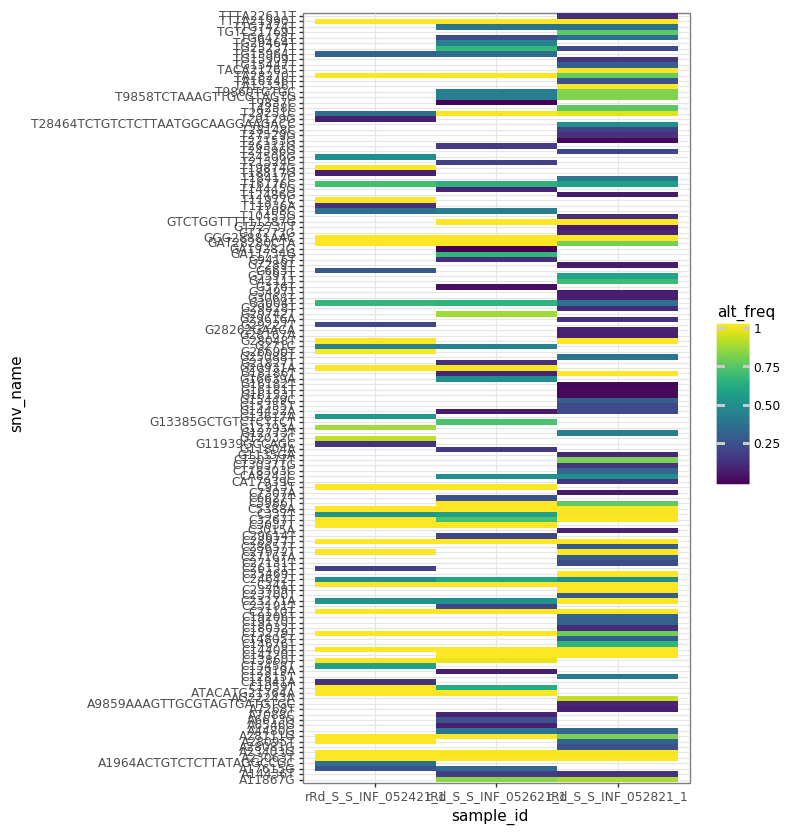

<ggplot: (307753385)>

In [609]:
(ggplot(gatk_df, aes(x='sample_id', y='snv_name', fill='alt_freq'))+
geom_tile()+
theme_bw()+
theme(figure_size=(5,10)))

In [599]:
gatk_dfp = gatk_df.pivot(index = 'snv_name', columns=['sample_id']).reset_index()
gatk_dfp.columns = ['_'.join(col).strip() for col in gatk_dfp.columns.values] #flatten multiindex
gatk_dfp = gatk_dfp.rename(columns={'snv_name_': 'snv_name'})
gatk_dfp.head()

,snv_name,DP_rRd_S_S_INF_052421_1,DP_rRd_S_S_INF_052621_1,DP_rRd_S_S_INF_052821_1,alt_freq_rRd_S_S_INF_052421_1,alt_freq_rRd_S_S_INF_052621_1,alt_freq_rRd_S_S_INF_052821_1
0,A11867G,NaN,35,24,NaN,0.828571,0.875000
1,A14436T,NaN,49,1168,NaN,0.183673,0.156678
2,A17615G,49,1651,NaN,0.265306,0.345245,NaN
3,A1964ACTGTCTCTTATAGGCCGC,22,NaN,NaN,0.363636,NaN,NaN
4,A23063T,22,29,160,1.000000,1.000000,1.000000


In [600]:
gatk_dfp = gatk_dfp.merge(gisaid_snvs_df[['snv_name', 'variant']], how='left', on='snv_name')

In [601]:
gatk_dfp.head()

,snv_name,DP_rRd_S_S_INF_052421_1,DP_rRd_S_S_INF_052621_1,DP_rRd_S_S_INF_052821_1,alt_freq_rRd_S_S_INF_052421_1,alt_freq_rRd_S_S_INF_052621_1,alt_freq_rRd_S_S_INF_052821_1,variant
0,A11867G,NaN,35,24,NaN,0.828571,0.875000,NaN
1,A14436T,NaN,49,1168,NaN,0.183673,0.156678,NaN
2,A17615G,49,1651,NaN,0.265306,0.345245,NaN,"[AH.3, B.1.36.33]"
3,A1964ACTGTCTCTTATAGGCCGC,22,NaN,NaN,0.363636,NaN,NaN,NaN
4,A23063T,22,29,160,1.000000,1.000000,1.000000,"[A.27, A.29, AP.1, B.1.1.136, B.1.1.7, B.1.324..."


In [610]:
gatk_df = gatk_df.merge(gisaid_snvs_df[['snv_name', 'variant', 'count', 'fraction']], how='left', on='snv_name')

In [501]:
gatk_df.DP = pd.to_numeric(gatk_df.DP)
gatk_df[['snv_name', 'DP', 'alt_freq', 'variant']].dropna().sort_values('DP', ascending=False)

# drop columns where variant list is > 1

,snv_name,DP,alt_freq,variant
88,C28657T,1619,0.288450,"[A.2, A.2.2, A.2.3, A.2.4, A.2.5, A.2.5.1, A.2..."
47,T16176C,1473,0.572980,[B.1.1.7]
73,C27131T,1305,0.240613,[B.1.160.15]
56,C19170T,1241,0.323127,"[AF.1, B.1.1.10, B.1.188, B.1.595.3, L.2, L.3,..."
1,C337T,1134,0.988536,[N.10]
40,C14805T,1092,0.302198,"[A.2, A.2.2, A.2.3, A.2.4, A.2.5, A.2.5.1, A.2..."
65,A23403G,1030,0.992233,"[A.18, A.19, A.2.5, A.2.5.1, A.2.5.2, AA.1, AA..."
36,C14408T,1007,0.999007,"[AA.1, AA.2, AA.3, AA.4, AA.5, AA.6, AA.7, AA...."
0,C241T,750,1.000000,"[AA.1, AA.2, AA.3, AA.4, AA.5, AA.6, AA.7, AA...."
35,C14120T,473,0.997886,[B.1.470]


In [496]:
gatk_df.dtypes

position         int64
REF             object
ALT             object
INFO            object
sample_info     object
GT              object
AD              object
AF              object
DP              object
ref_depth       object
alt_depth       object
snv_name        object
alt_freq       float64
variant         object
count           object
fraction        object
dtype: object